HuggingFace Interfaces
<p>
Transformer API, the model is served locally after downloading the model and tokenizer. The tokenzier converts text into embedding vectors

</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/rl

/content/drive/MyDrive/rl


# **LLM Benchmark Pipelines**

A LLM benchmark pipeline is the workflow behind improving the LLM performance on a specific benchmark.

Math Benchmark Example
-----------

Math Benchmark
SFT on math data
COT reasoning at inference time.


Before pipeline

After Pipeline


# Fine-tune + Chain-of-Thought + Self-Consistency on GSM8K (Colab Demo)

This notebook shows a **complete recipe** to improve math QA:

1. **Supervised Fine-Tuning (SFT)** on GSM8K-style data **with CoT** (we use GSM8K's rationale-like answers).
2. **CoT inference**: prompt with *"Let's think step by step."*
3. **Self-Consistency**: sample multiple generations and **majority-vote** the final answer.

⚠️ This is a *toy* run (few samples, tiny model) for speed. For real gains, scale up model/data and training steps.


In [ ]:
#@title Install dependencies
!pip -q install transformers==4.44.2 datasets==2.20.0 accelerate==0.34.2 safetensors peft==0.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 133.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.5.0 which is incompatible.


In [ ]:
#@title Imports & config
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import torch, re, random, numpy as np
from dataclasses import dataclass

MODEL_NAME = "sshleifer/tiny-gpt2"  # small for demo; swap to TinyLlama for better results
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device:{device}")

device:cuda


In [ ]:
#@title Load GSM8K (main) and build CoT-formatted samples
ds = load_dataset("gsm8k", "main")

def make_example(ex):
    # GSM8K answers typically include rationale + final answer like: '... \n#### 42'
    q = ex["question"].strip()
    rationale = ex["answer"].strip()
    prompt = f"Question: {q}\nLet's think step by step.\n"
    # We train to reproduce the rationale text directly
    text = prompt + rationale
    #print(f"make example: text:{text}")
    return {"text": text}

train_ds = ds["train"].shuffle(seed=SEED).select(range(1000)).map(make_example)  # small subset for demo
test_ds  = ds["test"].shuffle(seed=SEED).select(range(100)).map(make_example)
len(train_ds), len(test_ds)
print(f"type:{type(train_ds)}")
print(f"type train_ds[0]:{type(train_ds[0])}")
print(f"type train_ds[0] keys:{train_ds[0].keys()}")
print("-------")
print(f"type train_ds[0] text:{train_ds[0]['text']}")


Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

type:<class 'datasets.arrow_dataset.Dataset'>
type train_ds[0]:<class 'dict'>
type train_ds[0] keys:dict_keys(['question', 'answer', 'text'])
-------
type train_ds[0] text:Question: Mimi picked up 2 dozen seashells on the beach.  Kyle found twice as many shells as Mimi and put them in his pocket. Leigh grabbed one-third of the shells that Kyle found.  How many seashells did Leigh have?
Let's think step by step.
Mimi has 2 x 12 = <<2*12=24>>24 sea shells.
Kyle has 24 x 2 = <<24*2=48>>48 sea shells.
Leigh has 48 / 3 = <<48/3=16>>16 sea shells.
#### 16


In [ ]:
#@title Tokenize
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

MAX_LEN = 512
def tok_fn(batch):
    print(batch["text"])
    out = tok(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)
    out["labels"] = out["input_ids"].copy()
    return out

train_tok = train_ds.map(tok_fn, batched=True, remove_columns=train_ds.column_names)
test_tok  = test_ds.map(tok_fn,  batched=True, remove_columns=test_ds.column_names)
train_tok[0].keys()
# gee padded with 50256. Sure is a lot of wasted space
print(train_tok[0]['input_ids'])
print(train_tok[0]['attention_mask'])
print(train_tok[0]['labels'])
# does pytorch need the format below? We dont have that here
#dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
#columns=["input_ids", "token_type_ids", "attention_mask"],
#    label_cols=["label"],
# might be tf dataformat????

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

["Question: Mimi picked up 2 dozen seashells on the beach.  Kyle found twice as many shells as Mimi and put them in his pocket. Leigh grabbed one-third of the shells that Kyle found.  How many seashells did Leigh have?\nLet's think step by step.\nMimi has 2 x 12 = <<2*12=24>>24 sea shells.\nKyle has 24 x 2 = <<24*2=48>>48 sea shells.\nLeigh has 48 / 3 = <<48/3=16>>16 sea shells.\n#### 16", "Question: Frankie's parents let him have many pets. He has six more snakes than he has cats. He has one less parrot than cats. Six of his pets have four legs. He has 2 dogs. How many pets does he have in total?\nLet's think step by step.\nHe has 6 - 2 = <<6-2=4>>4 cats.\nHe has 4 - 1 = <<4-1=3>>3 parrots.\nHe has 4 + 6 = <<4+6=10>>10 snakes.\nHe has a total of 2 + 4 + 3 + 10 = <<2+4+3+10=19>>19 pets.\n#### 19", "Question: Olaf collects colorful toy cars. At first, his collection consisted of 150 cars. His family, knowing his hobby, decided to give him some toy cars. Grandpa gave Olaf twice as many t

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

["Question: Darrell and Allen's ages are in the ratio of 7:11. If their total age now is 162, calculate Allen's age 10 years from now.\nLet's think step by step.\nThe total ratio representing their ages is 7+11= <<7+11=18>>18\nSince the fraction of the ratio that represents Allen's age is 11/18, Allen's current age is 11/18*162 = <<11/18*162=99>>99\nIf Allen is currently 99 years old, in 10 years he will be 99+10 = <<99+10=109>>109 years old\n#### 109", "Question: Lorraine and Colleen are trading stickers for buttons. Each large sticker is worth a large button or three small buttons. A small sticker is worth one small button. A large button is worth three small stickers. Lorraine starts with 30 small stickers and 40 large stickers. She trades 90% of her small stickers for large buttons. She trades 50% of her large stickers for large buttons and trades the rest of them for small buttons. How many buttons does she have by the end?\nLet's think step by step.\nShe trades 27 small stickers 

In [ ]:
#@title Supervised Fine-Tuning (tiny run)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
args = TrainingArguments(
    output_dir="./math_cot_sft",
    num_train_epochs=5,              # increase to 2-3+ for better results
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=2e-4,              # a bit higher for tiny model
    logging_steps=20,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    report_to=[]
)

trainer = Trainer(model=model, args=args, train_dataset=train_tok, eval_dataset=test_tok)
trainer.train()
# save strategy epoch, steps

pytorch_model.bin:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,10.728700,10.720772
2,10.652400,10.642260
3,10.593400,10.585113
4,10.552400,10.549624
5,10.535800,10.541154


TrainOutput(global_step=625, training_loss=10.631507238769531, metrics={'train_runtime': 50.1848, 'train_samples_per_second': 99.632, 'train_steps_per_second': 12.454, 'total_flos': 2334720000.0, 'train_loss': 10.631507238769531, 'epoch': 5.0})


Epoch	Training Loss	Validation Loss
1	10.760600	10.758629
TrainOutput(global_step=125, training_loss=10.77796713256836, metrics={'train_runtime': 11.2865, 'train_samples_per_second': 88.602, 'train_steps_per_second': 11.075, 'total_flos': 466944000.0, 'train_loss': 10.77796713256836, 'epoch': 1.0})



In [ ]:
#@title Helper: extract final numeric answer from GSM8K-style rationale
final_num_pat = re.compile(r"####\s*(-?\d+)\s*$")

def extract_final_answer(text: str):
    # Try GSM8K '#### 42' pattern first
    m = final_num_pat.search(text)
    if m:
        return m.group(1)
    # Fallback: last integer in text
    nums = re.findall(r"-?\d+", text)
    return nums[-1] if nums else None

In [ ]:
#@title Baseline vs CoT + Self-Consistency eval on a small set
from transformers import pipeline

gen = pipeline("text-generation", model=model, tokenizer=tok, device=0 if torch.cuda.is_available() else -1)

def eval_set(dataset, n=50, self_consistency=False, samples=5, temperature=0.7):
    subset = dataset.select(range(n))
    correct = 0
    for ex in subset:
        # reconstruct question & gold from text (we still have ds for gold)
        # Better: re-load from original test set for exact gold
        # Here we parse gold from the concatenated rationale (after prompt)
        print(f"ex:{ex}")
        print(f"ex.keys:{ex.keys()}")
        text = ex["text"]
        # gold is last '#### N' in target text
        gold = extract_final_answer(text)
        # form prompt (everything before rationale)
        q = text.split("\nLet's think step by step.\n")[0]
        prompt = q + "\nLet's think step by step.\n"

        if not self_consistency:
            out = gen(prompt, max_new_tokens=200, do_sample=False)[0]["generated_text"]
            pred = extract_final_answer(out)
        else:
            votes = {}
            for _ in range(samples):
                out = gen(prompt, max_new_tokens=200, do_sample=True, temperature=temperature, top_p=0.95)[0]["generated_text"]
                ans = extract_final_answer(out)
                if ans is not None:
                    votes[ans] = votes.get(ans, 0) + 1
            pred = max(votes.items(), key=lambda x: x[1])[0] if votes else None

        correct += int(pred == gold)
    return correct / n

acc_greedy = eval_set(test_tok, n=30, self_consistency=False)
acc_sc5   = eval_set(test_tok, n=30, self_consistency=True, samples=5)
print({"greedy": acc_greedy, "self_consistency@5": acc_sc5})

ex:{'input_ids': [24361, 25, 44882, 290, 9659, 338, 9337, 389, 287, 262, 8064, 286, 767, 25, 1157, 13, 1002, 511, 2472, 2479, 783, 318, 25090, 11, 15284, 9659, 338, 2479, 838, 812, 422, 783, 13, 198, 5756, 338, 892, 2239, 416, 2239, 13, 198, 464, 2472, 8064, 10200, 511, 9337, 318, 767, 10, 1157, 28, 9959, 22, 10, 1157, 28, 1507, 4211, 1507, 198, 6385, 262, 13390, 286, 262, 8064, 326, 6870, 9659, 338, 2479, 318, 1367, 14, 1507, 11, 9659, 338, 1459, 2479, 318, 1367, 14, 1507, 9, 25061, 796, 9959, 1157, 14, 1507, 9, 25061, 28, 2079, 4211, 2079, 198, 1532, 9659, 318, 3058, 7388, 812, 1468, 11, 287, 838, 812, 339, 481, 307, 7388, 10, 940, 796, 9959, 2079, 10, 940, 28, 14454, 4211, 14454, 812, 1468, 198, 4242, 16003, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

KeyError: 'text'

### Notes
- For **meaningful gains**, replace the tiny model with something like `TinyLlama/TinyLlama-1.1B-Chat-v1.0` (use 8-bit loading) and train longer.
- Ensure **no data leakage** when evaluating (don’t fine-tune on the test set!).
- You can further improve results with **verification** (solve-then-check), or **RL** (e.g., PPO/GRPO) on math rewards.h


# **Sequence to Sequence Encoder and Decoders**

# **BERT**
Encoder Only with bidirectional attention


# **BART**
**Encoder-Decoder  for seq-seq applications like machine translation**
Encoder has bidirectional attention, decoder has causal attention

# **LLMs**
**Decoder Only with left to right causal attention**

# **HuggingFace APIs**

# **HF tokenizer**

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

text = "Hello world!"
tokens = tokenizer(text, return_tensors="pt")

print(tokens["input_ids"])     # tensor of token IDs
print(tokenizer.decode(tokens["input_ids"][0]))



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tensor([[ 101, 7592, 2088,  999,  102]])
[CLS] hello world! [SEP]


# **BERT Benchmarks**

In [ ]:
import numpy as np

# Patch np.array to ignore unsupported "copy=False" kwargs
_old_array = np.array
def _safe_array(obj, *args, **kwargs):
    # drop 'copy' arg if present (evaluate passes copy=False)
    kwargs.pop("copy", None)
    return _old_array(obj, *args, **kwargs)
np.array = _safe_array

print("✅ NumPy patched for evaluate compatibility:", np.__version__)

✅ NumPy patched for evaluate compatibility: 2.0.2


In [ ]:


# ======================
# 0) Install deps
# ======================
#!pip -q install "transformers>=4.44" "datasets>=2.20" "evaluate>=0.4" accelerate scikit-learn pandas
!pip install -U transformers datasets evaluate accelerate
import transformers
print(transformers.__version__)
import datasets
print(datasets.__version__)
import evaluate
print(evaluate.__version__)
import accelerate
print(accelerate.__version__)

4.57.1
4.2.0
0.4.6
1.10.1


In [ ]:
# removed evaluation_strategy from training args


# ======================
# 1) Imports & config
# ======================
from datasets import load_dataset, Value
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, set_seed
)
import evaluate, numpy as np, torch, pandas as pd
from collections import defaultdict

set_seed(42)

# Choose a model (fast default). Swap to "bert-base-uncased" for classic BERT.
MODEL_NAME = "distilbert-base-uncased"

TASKS = {
    "mrpc": dict(config="mrpc", sent_keys=("sentence1","sentence2"), num_labels=2, problem_type="single_label_classification"),
    "stsb": dict(config="stsb", sent_keys=("sentence1","sentence2"), num_labels=1, problem_type="regression"),
    "qqp":  dict(config="qqp",  sent_keys=("question1","question2"),  num_labels=2, problem_type="single_label_classification"),
}

def build_tokenize_with_labels(tokenizer, s1, s2, task_name, max_len=256):
    def _fn(batch):
        enc = tokenizer(batch[s1], batch[s2], truncation=True, max_length=max_len)
        # Ensure labels exist with the right dtype/key for Trainer
        if task_name == "stsb":
            enc["labels"] = [float(x) for x in batch["label"]]
        else:
            enc["labels"] = batch["label"]  # ints
        return enc
    return _fn

def get_compute_metrics(task_name):
    metric = evaluate.load("glue", TASKS[task_name]["config"])
    if task_name == "stsb":
        def compute_metrics(eval_pred):
            preds, labels = eval_pred
            preds = preds.squeeze()
            return metric.compute(predictions=preds, references=labels)
    else:
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            preds = np.argmax(logits, axis=-1)
            return metric.compute(predictions=preds, references=labels)
    return compute_metrics

# ======================
# 2) Train/Eval all tasks
# ======================
summary = defaultdict(dict)

for task_name, spec in TASKS.items():
    print(f"\n================ {task_name.upper()} ================")

    # Load dataset
    ds = load_dataset("glue", spec["config"])

    # STS-B labels must be float for regression
    if task_name == "stsb":
        ds = ds.cast_column("label", Value("float32"))

    # Tokenize (and keep labels!)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    s1, s2 = spec["sent_keys"]
    tok_fn = build_tokenize_with_labels(tokenizer, s1, s2, task_name, max_len=256)

    # Don't drop the "label" column; map will output input_ids/attention_mask/labels
    keep_cols = {s1, s2, "label"}
    remove_cols = [c for c in ds["train"].column_names if c not in keep_cols]
    ds_tok = ds.map(tok_fn, batched=True, remove_columns=remove_cols)

    # Model
    if task_name == "stsb":
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME, num_labels=1, problem_type="regression"
        )
    else:
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME, num_labels=spec["num_labels"]
        )

    # Data collator
    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Pick validation/test splits across GLUE variants
    val_split  = "validation" if "validation" in ds_tok else "validation_matched"
    test_split = "test" if "test" in ds_tok else ("test_matched" if "test_matched" in ds_tok else None)

    # Training args (light for Colab; adjust batch sizes if OOM)
    args = TrainingArguments(
        output_dir=f"./out-{task_name}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        learning_rate=2e-5,
        weight_decay=0.01,
        save_strategy="no",
        logging_steps=1000,
        fp16=torch.cuda.is_available(),
        report_to=[],
        load_best_model_at_end=False,
    )

    trainer = Trainer(
        model=model,
        args=args,
        tokenizer=tokenizer,
        data_collator=collator,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok[val_split],
        compute_metrics=get_compute_metrics(task_name),
    )

    trainer.train()
    eval_res = trainer.evaluate()
    test_res = {}
    if test_split:
        test_res = trainer.evaluate(ds_tok[test_split])

    summary[task_name]["val"]  = {k: float(v) for k,v in eval_res.items() if k.startswith("eval_")}
    summary[task_name]["test"] = {k: float(v) for k,v in test_res.items() if k.startswith("eval_")}
    print(f"\n{task_name.upper()} validation metrics:", summary[task_name]["val"])
    if test_res:
        print(f"{task_name.upper()} test metrics:", summary[task_name]["test"])

# ======================
# 3) Pretty results table
# ======================
rows = []
for task, res in summary.items():
    val  = {k.replace("eval_",""): v for k,v in res.get("val",{}).items()}
    test = {k.replace("eval_",""): v for k,v in res.get("test",{}).items()}
    rows.append({"task": task, **{f"val_{k}":v for k,v in val.items()}, **{f"test_{k}":v for k,v in test.items()}})
df = pd.DataFrame(rows).fillna("")
print("\n=== Summary ===")
print(df.to_string(index=False))


================ MRPC ================


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-289199305.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.643700
100,0.566000
150,0.515400
200,0.486800
250,0.420500
300,0.397700
350,0.367400
400,0.337200
450,0.386100



MRPC validation metrics: {'eval_loss': 0.39506796002388, 'eval_accuracy': 0.8480392156862745, 'eval_f1': 0.8923611111111112, 'eval_runtime': 0.2036, 'eval_samples_per_second': 2003.841, 'eval_steps_per_second': 63.848}
MRPC test metrics: {'eval_loss': 0.4305509030818939, 'eval_accuracy': 0.8081159420289855, 'eval_f1': 0.8586074327210593, 'eval_runtime': 0.803, 'eval_samples_per_second': 2148.293, 'eval_steps_per_second': 67.251}

================ STSB ================


stsb/train-00000-of-00001.parquet:   0%|          | 0.00/502k [00:00<?, ?B/s]

stsb/validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

stsb/test-00000-of-00001.parquet:   0%|          | 0.00/114k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5749 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1500 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1379 [00:00<?, ? examples/s]

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-289199305.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,3.907200
100,1.311100
150,0.915700
200,0.782300
250,0.791800
300,0.637000
350,0.640300
400,0.590700
450,0.527600
500,0.534000


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--glue/05234ba7acc44554edcca0978db5fa3bc600eeee66229abe79ff9887eacaf3ed/glue.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = float(pearsonr(preds, labels)[0])
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--glue/05234ba7acc44554edcca0978db5fa3bc600eeee66229abe79ff9887eacaf3ed/glue.py:98: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = float(spearmanr(preds, labels)[0])



STSB validation metrics: {'eval_loss': 0.5631492733955383, 'eval_pearson': 0.8663166761398315, 'eval_spearmanr': 0.8642415929873809, 'eval_runtime': 0.5622, 'eval_samples_per_second': 2667.976, 'eval_steps_per_second': 83.597}
STSB test metrics: {'eval_loss': 14.698888778686523, 'eval_pearson': nan, 'eval_spearmanr': nan, 'eval_runtime': 0.5633, 'eval_samples_per_second': 2448.079, 'eval_steps_per_second': 78.111}

================ QQP ================


qqp/train-00000-of-00001.parquet:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

qqp/validation-00000-of-00001.parquet:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

qqp/test-00000-of-00001.parquet:   0%|          | 0.00/36.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-289199305.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.648000
100,0.568600
150,0.501100
200,0.486900
250,0.483700
300,0.485100
350,0.463200
400,0.438300
450,0.455600
500,0.449000


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# =========================================================
# Colab demo: Supervised BERT + Bandit-style RL for QQP
# =========================================================
!pip -q install -U transformers datasets evaluate accelerate scikit-learn

import os, math, random, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from dataclasses import dataclass
from typing import Dict, List, Optional, Union

from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          get_linear_schedule_with_warmup)
from sklearn.metrics import classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128

# Supervised (baseline) params
SUP_TRAIN_EPOCHS = 1          # keep small for Colab speed; raise to improve baseline
SUP_LR = 2e-5
SUP_BATCH = 32
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06

# RL stage params
RL_STEPS = 2000               # number of RL minibatches (increase for stronger effect)
RL_BATCH = 32
RL_LR = 1e-5                  # smaller step for stability
RL_SUP_MIX = 0.2              # mix some CE to stabilize (0..1). Set 0 for pure RL.
BASELINE_BETA = 0.99          # moving-average baseline for variance reduction

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(SEED)

# ----------------------------
# Load subset of QQP (for speed)
# ----------------------------
raw = load_dataset("glue", "qqp")
# Filter out rows without labels (some test rows may be unlabeled)
raw = raw.filter(lambda ex: ex["label"] != -1)

# Take a manageable subset for Colab demo
train_small = raw["train"].shuffle(seed=SEED).select(range(50000))  # ~50k for speed; increase if you want
valid = raw["validation"]

tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize(batch):
    return tok(batch["question1"], batch["question2"], truncation=True, max_length=MAX_LEN)

train_enc = train_small.map(tokenize, batched=True)
valid_enc = valid.map(tokenize, batched=True)

cols = ["input_ids","attention_mask","token_type_ids","label"]
train_enc.set_format(type="torch", columns=[c for c in cols if c in train_enc.column_names])
valid_enc.set_format(type="torch", columns=[c for c in cols if c in valid_enc.column_names])

train_loader_sup = DataLoader(train_enc, batch_size=SUP_BATCH, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_enc, batch_size=128, shuffle=False)

# ----------------------------
# Model
# ----------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

# ----------------------------
# Supervised fine-tuning (CE)
# ----------------------------
def supervised_train(model, train_loader, epochs=1, lr=SUP_LR, weight_decay=WEIGHT_DECAY, warmup_ratio=WARMUP_RATIO):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = epochs * len(train_loader)
    sched = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(total_steps * warmup_ratio),
        num_training_steps=total_steps,
    )

    for ep in range(epochs):
        running = 0.0
        for i, batch in enumerate(train_loader, 1):
            batch = {k:v.to(DEVICE) for k,v in batch.items() if k in ["input_ids","attention_mask","token_type_ids","label"]}
            out = model(input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        token_type_ids=batch.get("token_type_ids", None),
                        labels=batch["label"])
            loss = out.loss
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            sched.step()
            running += loss.item()
            if i % 100 == 0:
                print(f"[SUP] epoch {ep+1} step {i}/{len(train_loader)} loss={running/100:.4f}")
                running = 0.0

def evaluate(model, loader, tag="VAL"):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k:v.to(DEVICE) for k,v in batch.items() if k in ["input_ids","attention_mask","token_type_ids","label"]}
            logits = model(input_ids=batch["input_ids"],
                           attention_mask=batch["attention_mask"],
                           token_type_ids=batch.get("token_type_ids", None)).logits
            yhat = logits.argmax(-1)
            preds.extend(yhat.cpu().tolist())
            labels.extend(batch["label"].cpu().tolist())
    print(f"\n[{tag}] classification report:")
    print(classification_report(labels, preds, digits=4))

print(">>> Supervised fine-tuning...")
supervised_train(model, train_loader_sup, epochs=SUP_TRAIN_EPOCHS)
evaluate(model, valid_loader, tag="VAL (after supervised)")

# ---------------------------------------
# RL stage: Bandit-style REINFORCE update
# ---------------------------------------
# We treat the model’s duplicate decision as a Bernoulli action:
#   a ~ Bernoulli(p) where p = softmax(logits)[:,1]
# Reward:
#   r = 1 if a == label, else 0   (you can replace with shaped reward)
# Loss:
#   L = - E[ (r - b) * log pi(a|x) ]   with moving baseline b to reduce variance
# Optional stabilization:
#   add CE_mix * CrossEntropyLoss to avoid drift.

def rl_minibatch(loader_iter, loader):
    try:
        batch = next(loader_iter)
    except StopIteration:
        loader_iter = iter(loader)
        batch = next(loader_iter)
    return batch, loader_iter

def log_bernoulli_prob(p, a):
    # a ∈ {0,1}, p ∈ (0,1)
    return a * torch.log(p + 1e-8) + (1 - a) * torch.log(1 - p + 1e-8)

# Prepare a fresh loader for RL (often just reuse train_enc)
train_loader_rl = DataLoader(train_enc, batch_size=RL_BATCH, shuffle=True, drop_last=True)
loader_iter = iter(train_loader_rl)

optimizer_rl = torch.optim.AdamW(model.parameters(), lr=RL_LR)

baseline = 0.0
model.train()
print("\n>>> RL fine-tuning (REINFORCE)...")
for step in range(1, RL_STEPS + 1):
    batch, loader_iter = rl_minibatch(loader_iter, train_loader_rl)
    batch = {k:v.to(DEVICE) for k,v in batch.items() if k in ["input_ids","attention_mask","token_type_ids","label"]}

    logits = model(input_ids=batch["input_ids"],
                   attention_mask=batch["attention_mask"],
                   token_type_ids=batch.get("token_type_ids", None)).logits
    probs_dup = F.softmax(logits, dim=-1)[:, 1]                               # p(a=1|x)
    actions = torch.bernoulli(probs_dup.detach()).long()                      # sample a (no grad)
    labels = batch["label"].long()

    # reward: correct decision -> 1, else 0 (could replace with shaped reward)
    rewards = (actions == labels).float()

    # moving average baseline
    baseline = BASELINE_BETA * baseline + (1 - BASELINE_BETA) * rewards.mean().item()
    adv = rewards - baseline                                                  # advantage estimate (detach later)

    # log pi(a|x)
    logp = log_bernoulli_prob(probs_dup, actions.float())

    # REINFORCE loss (note: stop gradient through advantage)
    reinforce_loss = -(adv.detach() * logp).mean()

    # optional stabilization: mix in a bit of supervised CE on the same batch
    if RL_SUP_MIX > 0:
        ce_loss = F.cross_entropy(logits, labels)
        loss = (1 - RL_SUP_MIX) * reinforce_loss + RL_SUP_MIX * ce_loss
    else:
        loss = reinforce_loss

    optimizer_rl.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer_rl.step()

    if step % 100 == 0:
        with torch.no_grad():
            # quick in-loop metric: accuracy using greedy argmax (not the sampled action)
            pred = logits.argmax(-1)
            acc = (pred == labels).float().mean().item()
        print(f"[RL] step {step}/{RL_STEPS} loss={loss.item():.4f} "
              f"reinforce={reinforce_loss.item():.4f} acc(batch)={acc:.3f} baseline={baseline:.3f}")

# Evaluate after RL
evaluate(model, valid_loader, tag="VAL (after RL)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 141.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 62.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


README.md: 0.00B [00:00, ?B/s]

qqp/train-00000-of-00001.parquet:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

qqp/validation-00000-of-00001.parquet:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

qqp/test-00000-of-00001.parquet:   0%|          | 0.00/36.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]

Filter:   0%|          | 0/363846 [00:00<?, ? examples/s]

Filter:   0%|          | 0/40430 [00:00<?, ? examples/s]

Filter:   0%|          | 0/390965 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Supervised fine-tuning...


RuntimeError: stack expects each tensor to be equal size, but got [33] at entry 0 and [29] at entry 1

In [ ]:
import pandas as pd
rows = []
for task, res in summary.items():
    val = {k.replace("eval_",""): v for k,v in res.get("val",{}).items()}
    test = {k.replace("eval_",""): v for k,v in res.get("test",{}).items()}
    rows.append({"task": task, **{f"val_{k}":v for k,v in val.items()}, **{f"test_{k}":v for k,v in test.items()}})
pd.DataFrame(rows)

# **HF SFT Formatting**

There are 2 options

prompt->complete format

chat format


In [ ]:
# pip install datasets transformers trl
from datasets import load_dataset, DatasetDict
import re

# 1) Load GSM8K (the "main" config is the standard split)
ds = load_dataset("gsm8k", "main")  # keys: 'train', 'test'
# Fields per entry: {'question': str, 'answer': str}

# 2) Utility to extract the final numeric answer after '#### '
final_pat = re.compile(r"####\s*([-+]?\d+(?:\.\d+)?)")
def extract_final_answer(solution: str):
    m = final_pat.search(solution)
    return m.group(1).strip() if m else None

# 3) Build prompt/completion pairs (keep full CoT as the target, or only final answer)
SYSTEM = (
    "You are a careful math tutor. Solve step by step, then finish with:"
    " 'Answer: <number>'."
)
USER_TEMPLATE = "Question: {q}\nWork it out step by step."
ASSISTANT_TEMPLATE = "{cot}\nAnswer: {ans}"

def to_prompt_completion(example):
    q = example["question"].strip()
    cot = example["answer"].strip()              # GSM8K includes full rationale
    ans = extract_final_answer(cot) or ""        # extract the final '#### 123' number

    prompt = f"{SYSTEM}\n\n{USER_TEMPLATE.format(q=q)}"
    completion = ASSISTANT_TEMPLATE.format(cot=cot, ans=ans)
    return {
        "prompt": prompt,
        "completion": completion,
        "text": prompt + "\n\n" + completion     # convenient single field for SFTTrainer
    }

formatted = ds.map(to_prompt_completion, remove_columns=ds["train"].column_names)
# formatted['train'][0].keys() -> ['prompt','completion','text']

# 4) (Optional) Save to JSONL for later
formatted["train"].to_json("gsm8k_sft_train.jsonl", orient="records", lines=True)
formatted["test"].to_json("gsm8k_sft_test.jsonl", orient="records", lines=True)
print("Wrote gsm8k_sft_train.jsonl and gsm8k_sft_test.jsonl")

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Wrote gsm8k_sft_train.jsonl and gsm8k_sft_test.jsonl


# **Chat Format**

In [ ]:
from datasets import DatasetDict
from transformers import AutoTokenizer
import re

final_pat = re.compile(r"####\s*([-+]?\d+(?:\.\d+)?)")
def extract_final_answer(solution: str):
    m = final_pat.search(solution)
    return m.group(1).strip() if m else None

SYSTEM_MSG = "You are a careful math tutor. Show reasoning, then finish with 'Answer: <number>'."

def to_messages(example):
    q = example["question"].strip()
    cot = example["answer"].strip()
    ans = extract_final_answer(cot) or ""
    assistant_text = f"{cot}\nAnswer: {ans}"

    return {
        "messages": [
            {"role": "system",    "content": SYSTEM_MSG},
            {"role": "user",      "content": f"Question: {q}\nWork it out step by step."},
            {"role": "assistant", "content": assistant_text},
        ]
    }

ds = load_dataset("gsm8k", "main")
chat_ds = ds.map(to_messages, remove_columns=ds["train"].column_names)

# Render with a chat template into a flat text field
model_name = "meta-llama/Llama-3.1-8B-Instruct"  # pick a model that defines a chat template
tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def to_chat_text(example):
    # By default, we want to train the assistant turn; set add_generation_prompt=False
    txt = tok.apply_chat_template(example["messages"], tokenize=False, add_generation_prompt=False)
    return {"text": txt}

chat_text = chat_ds.map(to_chat_text)

# Optional: save
chat_text["train"].to_json("gsm8k_chat_sft_train.jsonl", orient="records", lines=True)
chat_text["test"].to_json("gsm8k_chat_sft_test.jsonl", orient="records", lines=True)

Notes & tips
	•	Keep CoT or not?
	•	Keeping the full GSM8K rationale as the target (Option A/B above) generally yields better math performance than only supervising the final number.
	•	Answer marker
	•	GSM8K uses #### <number> inside answer. The regex above extracts it and we also append a clean Answer: <number> line for consistent targets.
	•	Eval split
	•	GSM8K’s official “test” is the public test; for proper reporting you may also create a validation split from train (e.g., 8:2).
	•	Packing
	•	Set packing=True in SFTConfig only if you know how your data collator handles multiple samples per sequence. For math CoT, many prefer packing=False.
	•	Chat templates
	•	Use a model whose tokenizer defines a chat_template (Llama 3.x, Mistral Instruct, etc.). Otherwise, create your own template or fall back to plain text format.

If you tell me the exact model family you’re targeting (Llama, Mistral, Qwen, etc.), I can drop in its recommended chat template and a ready-to-run training block tailored to it.

# **Sentence Completion as Context Bandit:**

**RLHF**
<ul>
Definitions. Not sure of correctness. Practice only
<li>LLM policy, $\pi_{llm}$ takes a conetxt $x$</li>
<li>LLM outputs $y$. y is the completion. Can also get the list or possible completions. </li>
<li>Reward model: $r(x,y)$ trained from human preferences data</li>
<li>PPO or another method updates $\pi_{llm}$ to maximize expected reward $\max_\theta \mathbb{E}{x \sim D, y \sim \pi\theta(\cdot|x)} [r(x,y)]$</li>
</ul>

**Mapping to context bandits**



```
          ┌─────────────────────────────┐
          │  User Prompt (context x)    │
          └──────────────┬──────────────┘
                         │
                         ▼
                ┌────────────────┐
                │ Policy πθ(y|x) │   ← (the LLM)
                └───────┬────────┘
                        │
                        ▼
             ┌────────────────────┐
             │  Output (action y) │
             └────────┬───────────┘
                      │
                      ▼
             ┌────────────────────┐
             │ Reward r(x,y)      │  ← (human or reward model)
             └────────────────────┘
```

# **Sentence Completion as MDP**

<b>RLHF as MDP optimization</b>

for prompt in dataset:
    
    
    # 1. Sample trajectory (tokens) from the LLM policy
    completion = model.sample(prompt)
    
    # 2. Get reward from reward model or human preference
    reward = reward_model(prompt, completion)
    
    # 3. Compute log-prob under policy
    logprob = model.logprob(prompt, completion)
    
    # 4. Update via PPO (policy gradient)
    advantage = reward - baseline_value
    loss = -advantage * logprob
    loss.backward()
    optimizer.step()




```
┌──────────────────────────────────────────────────────────────┐
│                        Environment (MDP)                     │
│                                                              │
│   ┌───────────────┐      ┌──────────────┐       ┌────────┐   │
│   │   State sₜ     │ ---> │ Action aₜ    │ --->  │ Reward │   │
│   │ (prefix tokens │      │ (next token) │       │ model  │   │
│   │  + prompt)    │      │              │       │ (human │   │
│   └───────────────┘      └──────────────┘       │  pref) │   │
│            ▲                     │              └────────┘   │
│            │                     ▼                           │
│      sₜ₊₁ = sₜ + aₜ  (deterministic transition)              │
│                                                              │
└──────────────────────────────────────────────────────────────┘
                  │
                  ▼
         ┌──────────────────┐
         │  Policy πθ       │
         │ (the LLM itself) │
         └──────────────────┘
                  │
                  ▼
        Generates tokens y₁…y_T
                  │
                  ▼
      ┌───────────────────────────────┐
      │  Reward model / Human feedback│
      │  assigns R(x, y₁:T)           │
      └───────────────────────────────┘
                  │
                  ▼
        ┌────────────────────────────┐
        │ Policy Optimization (PPO)  │
        │ Update θ ← θ + ∇θ (R * log πθ) │
        └────────────────────────────┘
```

**RLHF as MDP Equations for sentence completion**

<ul>
<li>Policy: $π_θ(a_t|s_t) = \text{softmax}(W h_t)$</li>
<li>Return: $R_T = f(\text{output quality, human preference})$</li>
<li>RLHF Objective:$J(θ) = \mathbb{E}_{x, y \sim π_θ} [R(x, y)] - β \, KL[π_θ || π_0]$</li>
</ul>

**Mapping RLHF into Gridworld style MDP for sentence completion**
<ul>
<li>State $s_t$ = prompt + current prefix. Each griworld cell is a prefix of words. </li>
<li>$a_t$ = next token (or token class). There are many possible simplifiactions for next token. Reduce choices by creating next token classes,reduce num states by defining limited choice of actions. $A={a_{affirm},a_{deny},a_{ask},a_{justify},a_{end}}$. action end is Limit the number of episodes, T or End of sentence.  
</li>
<li>Assume actions: Ask-Clarifying (A), Answer-Directly (D), Hedge (H), Cite/Justify (J), End (E).</li>
<li>Reward model,helpful & harmless → +1, unhelpful / toxic / off-topic → −1, 	neutral → 0 </li>
<li>The difference between this and contextual bandit is credit assignment which allows more flexibility and if done correctly should result in better performance. Have to prove with demo</li>
<li>The agent learns a policy like “A → J → D → E” </li>
<li>TBD: how to simulate reward shaping? </li>
</ul>


**Terminal reward (at E):**
<ul>
  <li>Correct & helpful & civil: +1</li>
	<li>Incorrect or unhelpful: −1</li>
	<li>Meh/neutral: 0</li>
</ul>


**Optional shaping during the episode (small bonuses/penalties):**
<ul>
<li>A (Ask) when ambiguity present: +0.1</li>
<li>J (Justify) with verifiable claim/link: +0.1</li>
<li>H (Hedge) when uncertainty is high: +0.05</li>
<li>Overlong outputs or redundancy: −0.05</li>
<li>Exceeding max steps before E: −0.1</li>
</ul>

In [ ]:
# pseudo code for controller which is part of the agent. May be called workflow in recent controversy
# Pseudocode (sketch). The controller is the π_macro. Could be anohther policy net. Another NN.
for prompt in dataset:
    s = init_state(prompt)
    traj = []
    done = False

    while not done:
        # π_macro selects one of {A,D,H,J,E} given current state (prefix)
        a = pi_macro(s)                         # policy over macro-actions
        directive = action_to_directive(a)      # short system text for the LLM
        llm_out = call_llm(s, directive)        # one short turn (question, answer, hedge, or cite)
        s = append(s, llm_out)
        traj.append((s, a, llm_out))

        if a == "E" or reached_max_steps(s):
            done = True

    # Terminal reward via reward model (or human)
    R = reward_model(prompt, s)                 # scalar

    # Policy gradient update on π_macro (optionally also on token policy)
    for (state_i, action_i, _) in traj:
        loss += -logprob(pi_macro, action_i | state_i) * (R - baseline(state_i))

    optimize(loss)

# **Minimal prompt templates (drop-in)**

<ul>
  <li>A:“You may ask one brief clarifying question and stop. Question:”</li>
	<li>J:
“Provide one sentence justification or citation, then stop. Justification:”</li>
	<li>	H:
“If unsure, briefly state uncertainty and list the top 2 likely completions. Then stop.”</li>
	<li>	D:
“Fill the blank with a single concise completion. Answer only the blank.”</li>
	<li>	E:
“Stop now.” (or simply take no further turn)</li>
</ul>


In [ ]:
# ============================================================
# RLHF-as-MDP (macro actions) — minimal working scaffold
# Actions: Ask (A), Direct (D), Hedge (H), Justify (J), End (E)
# Policy: small neural net over a simple state embedding
# Env: sentence completion "The treaty was signed in ___"
# Reward: terminal + shaping (correct=+1, wrong=-1, neutral=0)
# ============================================================

import math, random, re
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

# -----------------------------
# Toggle: use real HF transformers or a built-in mock LLM
# -----------------------------
USE_TRANSFORMERS = False
HF_MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # small & public
MAX_TOKENS = 32
DEVICE = "cpu"   # set to "cuda" if you have a GPU and torch installed

# -----------------------------
# Optional HF setup (only if USE_TRANSFORMERS=True)
# -----------------------------
if USE_TRANSFORMERS:
    import torch
    from transformers import AutoTokenizer, AutoModelForCausalLM
    tok = AutoTokenizer.from_pretrained(HF_MODEL_ID)
    model = AutoModelForCausalLM.from_pretrained(HF_MODEL_ID, torch_dtype=torch.float32, device_map=None)
    model.to(DEVICE)
    model.eval()

def hf_generate(prompt: str, directive: str, max_new_tokens: int = MAX_TOKENS) -> str:
    """Generate one short turn using HF transformers (single step)."""
    text = prompt + "\n" + directive
    inputs = tok(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.95,
            pad_token_id=tok.eos_token_id,
        )
    gen = tok.decode(out[0], skip_special_tokens=True)
    # Return only the tail after the directive
    return gen.split(directive, 1)[-1].strip()

# -----------------------------
# Mock LLM (works offline)
# -----------------------------
def mock_llm(prompt: str, directive: str) -> str:
    """Heuristic one-liners to simulate A/D/H/J/E behavior."""
    prompt_l = prompt.lower()
    if "which treaty" in directive.lower():
        return "Which treaty do you mean (e.g., Versailles, Tordesillas, Waitangi)?"
    if directive.startswith("D:"):
        # Guess most likely completion
        if "versailles" in prompt_l:
            return "1919."
        return "It depends; often 1919 for Versailles."
    if directive.startswith("H:"):
        return "Not fully certain; likely 1919 or 1840."
    if directive.startswith("J:"):
        return "Versailles was signed after WWI in 1919 at the Palace of Versailles."
    if directive.startswith("E:"):
        return ""  # End produces no text
    # Default Ask
    return "Which treaty do you mean?"

# -----------------------------
# Macro-action directives (small system prompts)
# -----------------------------
A_DIRECTIVE = "A: Ask one brief clarifying question, then stop.\nQ:"
D_DIRECTIVE = "D: Fill the blank with a single concise completion (just the phrase)."
H_DIRECTIVE = "H: If unsure, state uncertainty and list top 1–2 likely completions briefly."
J_DIRECTIVE = "J: Provide one-sentence justification or citation, then stop."
E_DIRECTIVE = "E: Stop now."

ACTIONS = ["A", "D", "H", "J", "E"]
ACTION_TO_DIR = {
    "A": A_DIRECTIVE,
    "D": D_DIRECTIVE,
    "H": H_DIRECTIVE,
    "J": J_DIRECTIVE,
    "E": E_DIRECTIVE,
}

# -----------------------------
# Toy dataset & ambiguity tag
# -----------------------------
@dataclass
class Example:
    prompt: str
    target: str           # canonical correct completion (simple check)
    ambiguous: bool       # whether asking helps
    hint: Optional[str] = None  # user reply to A, if asked

DATASET = [
    Example(
        prompt="Complete: The treaty was signed in ___ (Treaty of Versailles).",
        target="1919",
        ambiguous=False,
        hint=None,
    ),
    Example(
        prompt="Complete: The treaty was signed in ___ (unspecified).",
        target="1919",      # assume annotator expects Versailles here
        ambiguous=True,
        hint="The Versailles treaty.",
    ),
]

# -----------------------------
# Reward model (toy)
# -----------------------------
def terminal_reward(full_text: str, expected: str) -> float:
    """Terminal reward: +1 if expected number appears as a whole token, -1 if clearly wrong, 0 otherwise."""
    # normalize
    txt = full_text.lower()
    exp = expected.lower()
    if re.search(rf"\b{re.escape(exp)}\b", txt):
        return 1.0
    # obvious wrong year heuristics
    if re.search(r"\b(1800|1840|1945|2020)\b", txt):
        return -1.0
    return 0.0

def shaping_reward(action: str, state_text: str, ex: Example) -> float:
    """Light shaping: encourage A/J/H when useful; discourage rambling."""
    r = 0.0
    if action == "A" and ex.ambiguous:
        r += 0.1
    if action == "J":
        r += 0.1
    if action == "H" and "unspecified" in ex.prompt.lower():
        r += 0.05
    # tiny penalty if very long
    if len(state_text) > 500:
        r -= 0.05
    return r

# -----------------------------
# Simple state encoder (tiny features)
# -----------------------------
def state_embed(prefix: str, ex: Example) -> List[float]:
    """Very tiny handcrafted features -> use as input to macro policy."""
    L = len(prefix)
    has_year = 1.0 if re.search(r"\b(1[5-9]\d{2}|20\d{2})\b", prefix) else 0.0
    ambiguous = 1.0 if ex.ambiguous else 0.0
    asked = 1.0 if "?" in prefix else 0.0
    justified = 1.0 if "because" in prefix.lower() or "at the palace" in prefix.lower() else 0.0
    return [L/1000.0, has_year, ambiguous, asked, justified, 1.0]  # last is bias term

# -----------------------------
# Tiny policy (softmax over actions) with REINFORCE
# -----------------------------
class MacroPolicy:
    def __init__(self, n_in: int, n_actions: int, lr=0.1):
        random.seed(0)
        self.W = [[(random.random() - 0.5)*0.2 for _ in range(n_in)] for _ in range(n_actions)]
        self.lr = lr

    def logits(self, x: List[float]) -> List[float]:
        return [sum(wi*xi for wi, xi in zip(wrow, x)) for wrow in self.W]

    def softmax(self, z: List[float]) -> List[float]:
        m = max(z)
        exps = [math.exp(v - m) for v in z]
        s = sum(exps)
        return [e/s for e in exps]

    def sample(self, x: List[float]) -> Tuple[int, List[float], List[float]]:
        z = self.logits(x)
        p = self.softmax(z)
        # categorical sample
        r = random.random()
        acc = 0.0
        idx = 0
        for i, pi in enumerate(p):
            acc += pi
            if r <= acc:
                idx = i
                break
        return idx, z, p

    def update(self, grads: List[List[float]]):
        # grads is list of dL/dW rows same shape as W
        for i in range(len(self.W)):
            for j in range(len(self.W[0])):
                self.W[i][j] -= self.lr * grads[i][j]

def one_hot(n, i):
    v = [0.0]*n
    v[i] = 1.0
    return v

# -----------------------------
# Episode rollout (one example)
# -----------------------------
MAX_STEPS = 4  # A/J/H/D then E typically

def call_one_turn(ex: Example, prefix: str, action: str) -> str:
    directive = ACTION_TO_DIR[action]
    if USE_TRANSFORMERS:
        out = hf_generate(prefix, directive, max_new_tokens=24)
    else:
        out = mock_llm(prefix, directive)
    # If we asked a question and example provides a hint, simulate user reply
    if action == "A" and ex.hint:
        out = out.strip() + "\nUser: " + ex.hint
    return out.strip()

def run_episode(policy: MacroPolicy, ex: Example) -> Tuple[float, List[Tuple[List[float], int, List[float]]], str]:
    prefix = ex.prompt
    traj = []
    total_shaping = 0.0

    for t in range(MAX_STEPS):
        x = state_embed(prefix, ex)
        a_idx, logits, probs = policy.sample(x)
        action = ACTIONS[a_idx]

        # If we choose End immediately and nothing produced yet, force at least one step
        if action == "E" and t == 0:
            # resample non-E
            a_idx = random.choice([0,1,2,3])  # A/D/H/J
            action = ACTIONS[a_idx]

        out = "" if action == "E" else call_one_turn(ex, prefix, action)
        if action != "E":
            prefix = (prefix + "\n" + out).strip()

        # shaping reward
        total_shaping += shaping_reward(action, prefix, ex)
        traj.append((x, a_idx, probs))

        if action == "E":
            break

    # terminal reward
    R = terminal_reward(prefix, ex.target) + total_shaping
    return R, traj, prefix

# -----------------------------
# REINFORCE update over the macro-policy
# -----------------------------
def policy_gradient_update(policy: MacroPolicy, traj, R: float, baseline: float = 0.0):
    """Single-trajectory REINFORCE with baseline."""
    advantage = R - baseline
    # Build dL/dW via (p - y) * x for softmax cross-entropy scaled by -advantage
    # loss = - advantage * sum_t log pi(a_t|s_t)
    # ∇ = -adv * (y - p) * x  → we implement via grads accumulation
    n_actions = len(ACTIONS)
    n_in = len(traj[0][0])

    # initialize grads
    grads = [[0.0]*n_in for _ in range(n_actions)]

    for (x, a_idx, probs) in traj:
        y = one_hot(n_actions, a_idx)
        # grad wrt logits: (p - y); loss has minus sign with advantage → scale by advantage
        for i in range(n_actions):
            coeff = (probs[i] - y[i]) * advantage
            for j in range(n_in):
                grads[i][j] += coeff * x[j]

    # apply
    policy.update(grads)

# -----------------------------
# Training loop (tiny)
# -----------------------------
random.seed(42)
policy = MacroPolicy(n_in=len(state_embed("", DATASET[0])), n_actions=len(ACTIONS), lr=0.3)

EPOCHS = 40
print_every = 5
baseline = 0.0
beta = 0.9  # baseline moving average factor

for epoch in range(1, EPOCHS+1):
    rewards = []
    for ex in DATASET:
        R, traj, full_text = run_episode(policy, ex)
        rewards.append(R)
        policy_gradient_update(policy, traj, R, baseline)
    # update baseline (moving average return)
    meanR = sum(rewards)/len(rewards)
    baseline = beta*baseline + (1-beta)*meanR
    if epoch % print_every == 0:
        print(f"Epoch {epoch:02d} | meanR={meanR:+.3f} | baseline={baseline:+.3f}")

# -----------------------------
# Inspect learned behavior
# -----------------------------
def greedy_action(policy: MacroPolicy, x):
    # pick argmax
    z = policy.logits(x)
    p = policy.softmax(z)
    return ACTIONS[p.index(max(p))], p

print("\n=== Policy snapshot on examples (greedy) ===")
for ex in DATASET:
    x = state_embed(ex.prompt, ex)
    a, p = greedy_action(policy, x)
    print(f"Prompt: {ex.prompt}")
    print(f" Greedy first action: {a} | probs={dict(zip(ACTIONS, [round(pi,3) for pi in p]))}")
    R, traj, final_text = run_episode(policy, ex)
    print(f" Sampled episode reward: {R:+.3f}")
    print(" ----- Final text -----")
    print(final_text)
    print("-----------------------\n")

# **Public data sentence completion**

**CLOTH:**
```
#!pip install datasets
from datasets import load_dataset

cloth = load_dataset("tatsu-lab/cloth", "middle")  # or "high"

print(cloth)
print(cloth["train"][0])
```

**SCDE:**
https://github.com/liuhuanyong/SCDE.git
<ul>
<li>SCDE/train.json</li>
<li>SCDE/dev.json</li>
<li>SCDE/test.json</li>
</ul>

**Who did What (WDW)**

git clone https://github.com/tticoin/who_did_what.git

```
from datasets import load_dataset
wdw = load_dataset("toshihikoyanase/who_did_what")
print(wdw["train"][0])
```



# **NOT READY Creating synthetic data**

**Polysemy**

This is WSD, word sense disambiguation

<ul>
<li>loop through 40k english word vocabulary</li>
<li>use LLM to generate if polysemy or not and create sentences with different meanings. The polysemy words need a clarifiying question to esablish context. i.e. jaguar cat or car?</li>
<li>use LLM to auto generate clarifying questions</li>
</ul>



<table>
<thead><td>word</td><td>ambiguous sentence</td><td>clarifying question</td><td>Disambiguating Answer</td></thead>

<tr><td>Bank</td><td>“I’m going to the bank.”</td><td>Do you mean the bank where you keep money, or the bank beside the river?</td><td>I mean the financial bank.</td></tr>

<tr><td>Light</td><td>“Can you turn on the light thing?”
</td><td>Are you referring to illumination or something that’s not heavy?
</td><td></td></tr>

<tr><td>Run</td><td>“She’s been running all day.”
</td><td>Is she exercising or managing something?
</td><td></td></tr>

<tr><td>Head</td><td>“The head is very busy today.”
</td><td>Do you mean the body part or the leader of a group?
</td><td></td></tr>

<tr><td>Book</td><td>“I need to book it now.”
</td><td>Are you saying you need to reserve something or read a book?
</td><td></td></tr>

<tr><td>Right</td><td>“You have the right one.”
</td><td>Do you mean correct, or right-hand side?
</td><td></td></tr>

<tr><td>Fall</td><td>“The fall was unexpected.”
</td><td>Are you talking about autumn or someone falling down?
</td><td></td></tr>

<tr><td>Change</td><td>“Can you give me some change?”
</td><td>Are you asking for coins or asking me to alter something?
</td><td></td></tr>

<tr><td>Seal</td><td>“The seal broke.”
</td><td>Do you mean the animal or the thing that closes tightly?
</td><td></td></tr>

<tr><td>Watch</td><td>“He bought a new watch.”
</td><td>Are you talking about a device for time or the act of observing?
</td><td></td></tr>

</table>

**ChatGPT converted to jsonl file and downloaded and uploaded to /gdrive**

clarifying_polysemy.jsonl



In [ ]:
# ============================================================
# RLHF for Clarifying Polysemy (Minimal, Pure Python)
# - Macro actions: Ask (A), Answer (D), End (E)
# - Contexts are ambiguous sentences with a gold sense
# - Reward model: terminal reward for correctness + small bonus for asking when ambiguous
# - Optimizer: REINFORCE (policy gradient) on a tiny softmax policy
# ============================================================

import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

random.seed(42)

# -----------------------------
# Data: ambiguous sentences with gold sense
# Each item also includes a simulated user reply used if the agent asks a clarifying question.
# -----------------------------
@dataclass
class PolysemyExample:
    id: str
    word: str
    prompt: str                  # ambiguous sentence
    senses: List[str]            # possible senses (labels)
    gold: str                    # correct sense label
    ambiguous: bool              # whether asking is useful
    user_reply_if_asked: str     # what the "user" says if asked
    # optional knowledge to produce a better answer after disambiguation
    fact_for_answer: Optional[str] = None

DATASET: List[PolysemyExample] = [
    PolysemyExample(
        id="bank-1",
        word="bank",
        prompt="I'm going to the bank after work.",
        senses=["financial institution", "river edge"],
        gold="financial institution",
        ambiguous=True,
        user_reply_if_asked="I mean the financial bank.",
        fact_for_answer="The bank closes at 6pm."
    ),
    PolysemyExample(
        id="light-1",
        word="light",
        prompt="Can you carry the light box?",
        senses=["illumination", "low weight"],
        gold="low weight",
        ambiguous=True,
        user_reply_if_asked="I mean not heavy.",
        fact_for_answer="It weighs less than 2 kg."
    ),
    PolysemyExample(
        id="run-1",
        word="run",
        prompt="She has to run the shop on weekends.",
        senses=["exercise", "manage/operate"],
        gold="manage/operate",
        ambiguous=False,
        user_reply_if_asked="She means manage the shop.",
        fact_for_answer="Hours are 10am–6pm."
    ),
    PolysemyExample(
        id="seal-1",
        word="seal",
        prompt="The seal broke.",
        senses=["animal", "closure/stamp"],
        gold="closure/stamp",
        ambiguous=True,
        user_reply_if_asked="The closure on the envelope.",
        fact_for_answer="You can reseal it with tape."
    ),
    PolysemyExample(
        id="watch-1",
        word="watch",
        prompt="He bought a new watch.",
        senses=["to observe", "timepiece"],
        gold="timepiece",
        ambiguous=False,
        user_reply_if_asked="A wristwatch.",
        fact_for_answer="It's water-resistant."
    ),
]

# -----------------------------
# Macro actions & simple templates
# -----------------------------
ACTIONS = ["A", "D", "E"]  # Ask, Direct answer, End

def ask_directive(ex: PolysemyExample) -> str:
    # What the assistant says if it chooses Ask (A)
    senses = " or ".join(ex.senses)
    return f"Do you mean {senses}?"

def direct_answer(ex: PolysemyExample, sense: Optional[str]) -> str:
    # What the assistant answers if it chooses Direct (D)
    if sense is None:
        # guessing before clarification: pick a likely guess (random baseline)
        guess = random.choice(ex.senses)
        if ex.fact_for_answer and guess == ex.gold:
            return f"It refers to {guess}. {ex.fact_for_answer}"
        return f"It refers to {guess}."
    else:
        # after clarification: answer with the provided sense
        if ex.fact_for_answer:
            return f"It refers to {sense}. {ex.fact_for_answer}"
        return f"It refers to {sense}."

# -----------------------------
# Reward model (bandit-style)
# -----------------------------
def terminal_reward(
    ex: PolysemyExample,
    chosen_sense: Optional[str],
    asked: bool,
) -> float:
    """
    Reward:
      +1   if final answer uses the correct sense
       0   if no clear sense or neutral
      -1   if the answer confidently picks the wrong sense
    Shaping:
      +0.1 bonus for asking when ex.ambiguous == True
    """
    r = 0.0
    # correctness
    if chosen_sense is not None:
        if chosen_sense == ex.gold:
            r += 1.0
        else:
            r -= 1.0
    # shaping bonus for useful clarification
    if asked and ex.ambiguous:
        r += 0.1
    return r

# -----------------------------
# Tiny state encoder (features)
# We'll keep it dumb: just a few binary/numeric indicators per example + bias term.
# -----------------------------
def state_features(ex: PolysemyExample, asked: bool, clarified_sense: Optional[str]) -> List[float]:
    # features: [ambiguous?, asked?, clarified?, known_fact?, bias]
    f_amb = 1.0 if ex.ambiguous else 0.0
    f_ask = 1.0 if asked else 0.0
    f_clr = 1.0 if clarified_sense is not None else 0.0
    f_fact = 1.0 if ex.fact_for_answer is not None else 0.0
    return [f_amb, f_ask, f_clr, f_fact, 1.0]

# -----------------------------
# Softmax policy over macro actions (A, D, E) using a linear head
# One set of weights shared across all examples (to keep it tiny).
# -----------------------------
class MacroPolicy:
    def __init__(self, n_in: int, n_actions: int, lr: float = 0.2):
        # Initialize small random weights
        rng = random.Random(0)
        self.W = [[(rng.random() - 0.5) * 0.1 for _ in range(n_in)] for __ in range(n_actions)]
        self.lr = lr

    def _logits(self, x: List[float]) -> List[float]:
        return [sum(wi * xi for wi, xi in zip(wrow, x)) for wrow in self.W]

    @staticmethod
    def _softmax(z: List[float]) -> List[float]:
        m = max(z)
        exps = [math.exp(v - m) for v in z]
        s = sum(exps)
        return [e / s for e in exps]

    def probs(self, x: List[float]) -> List[float]:
        return self._softmax(self._logits(x))

    def sample(self, x: List[float]) -> Tuple[int, List[float]]:
        p = self.probs(x)
        r = random.random()
        acc = 0.0
        idx = 0
        for i, pi in enumerate(p):
            acc += pi
            if r <= acc:
                idx = i
                break
        return idx, p

    def update(self, grads: List[List[float]]):
        for i in range(len(self.W)):
            for j in range(len(self.W[0])):
                self.W[i][j] += self.lr * grads[i][j]  # gradient ascent

# -----------------------------
# Utility
# -----------------------------
def one_hot(n: int, i: int) -> List[float]:
    v = [0.0] * n
    v[i] = 1.0
    return v

# -----------------------------
# Single episode rollout for one example
# The agent can take up to 3 steps: A / D / E (End ends immediately)
# If it asks and the example is ambiguous, we reveal the sense via the user reply.
# -----------------------------
MAX_STEPS = 3

def run_episode(policy: MacroPolicy, ex: PolysemyExample, baseline: float = 0.0):
    asked = False
    clarified_sense: Optional[str] = None
    traj = []  # list of (features x, action_index, probs)

    # keep a simple transcript (purely for printing)
    transcript: List[str] = [f"Prompt: {ex.prompt}"]

    for t in range(MAX_STEPS):
        x = state_features(ex, asked, clarified_sense)
        a_idx, probs = policy.sample(x)
        a = ACTIONS[a_idx]

        if a == "A":  # Ask for clarification
            asked = True
            transcript.append("Assistant (Ask): " + ask_directive(ex))
            # simulate user reply if ambiguous; else generic confirmation of gold
            user_reply = ex.user_reply_if_asked or f"It means {ex.gold}."
            transcript.append("User: " + user_reply)
            # extract the clarified sense from the reply
            # (very simple heuristic)
            if ex.gold in user_reply.lower():
                clarified_sense = ex.gold
            else:
                # fall back to gold if ambiguous flag is set
                clarified_sense = ex.gold if ex.ambiguous else None

        elif a == "D":  # Direct answer (before or after asking)
            # choose the sense: if clarified, use it; otherwise guess randomly
            sense = clarified_sense if clarified_sense else None
            # If we randomly guess wrong, the reward model will penalize later
            # Print the answer
            ans = direct_answer(ex, sense)
            transcript.append("Assistant (Answer): " + ans)

        elif a == "E":  # End episode
            transcript.append("Assistant (End).")
            traj.append((x, a_idx, probs))
            break

        # log the step AFTER choosing action (for gradient)
        traj.append((x, a_idx, probs))

    # Decide what sense we "committed to" at the end (look back at last Answer)
    # If never answered, chosen_sense = None (neutral/zero reward).
    chosen_sense = clarified_sense
    # crude heuristic: if we answered with a guessed sense earlier without clarification,
    # we approximate that guess by taking the first sense if no clarification happened.
    # (This keeps the example minimal—reward model will handle the penalty/neutral.)
    if chosen_sense is None:
        # inspect transcript for "It refers to ..." to extract guessed sense if any
        for line in transcript[::-1]:
            if "Assistant (Answer): It refers to " in line:
                if "financial" in line.lower():
                    chosen_sense = "financial institution"
                elif "river" in line.lower():
                    chosen_sense = "river edge"
                elif "not heavy" in line.lower() or "weighs less" in line.lower():
                    chosen_sense = "low weight"
                elif "manage" in line.lower():
                    chosen_sense = "manage/operate"
                elif "closure" in line.lower() or "seal" in line.lower():
                    chosen_sense = "closure/stamp"
                elif "watch" in line.lower() or "time" in line.lower():
                    chosen_sense = "timepiece"
                break

    # Compute reward
    R = terminal_reward(ex, chosen_sense, asked)

    return R, traj, transcript

# -----------------------------
# Policy Gradient (REINFORCE) update
# -----------------------------
def policy_gradient_update(policy: MacroPolicy, traj, R: float, baseline: float = 0.0):
    advantage = R - baseline
    n_actions = len(ACTIONS)
    n_in = len(traj[0][0])

    # accumulate grads over steps: grad(log pi(a|x)) = (y - p) * x  (for softmax)
    grads = [[0.0] * n_in for _ in range(n_actions)]
    for (x, a_idx, probs) in traj:
        y = one_hot(n_actions, a_idx)
        for i in range(n_actions):
            coeff = (y[i] - probs[i]) * advantage  # ascent
            for j in range(n_in):
                grads[i][j] += coeff * x[j]
    policy.update(grads)

# -----------------------------
# Training loop
# -----------------------------
def train(num_epochs: int = 50, episodes_per_epoch: int = 40, lr: float = 0.2):
    policy = MacroPolicy(n_in=len(state_features(DATASET[0], False, None)),
                         n_actions=len(ACTIONS),
                         lr=lr)
    baseline = 0.0
    beta = 0.95  # moving average baseline factor

    for ep in range(1, num_epochs + 1):
        epoch_rewards = []
        for _ in range(episodes_per_epoch):
            ex = random.choice(DATASET)
            R, traj, _ = run_episode(policy, ex, baseline)
            epoch_rewards.append(R)
            policy_gradient_update(policy, traj, R, baseline)
        meanR = sum(epoch_rewards) / len(epoch_rewards)
        baseline = beta * baseline + (1 - beta) * meanR
        if ep % 5 == 0:
            print(f"Epoch {ep:02d} | meanR={meanR:+.3f} | baseline={baseline:+.3f}")

    return policy

# -----------------------------
# Evaluation: show learned first action and a sample rollout per example
# -----------------------------
def greedy_action(policy: MacroPolicy, ex: PolysemyExample, asked=False, clarified=None):
    x = state_features(ex, asked, clarified)
    # greedy pick
    z = [sum(wi * xi for wi, xi in zip(wrow, x)) for wrow in policy.W]
    # softmax then argmax
    m = max(z)
    exps = [math.exp(v - m) for v in z]
    s = sum(exps)
    p = [e / s for e in exps]
    idx = p.index(max(p))
    return ACTIONS[idx], p

def demo(policy: MacroPolicy):
    print("\n=== GREEDY FIRST ACTIONS ===")
    for ex in DATASET:
        a, p = greedy_action(policy, ex)
        print(f"- {ex.id:8s} ({'amb' if ex.ambiguous else 'clear'}): first_action={a} | probs={dict(zip(ACTIONS, [round(x,3) for x in p]))}")

    print("\n=== SAMPLE ROLLOUTS ===")
    for ex in DATASET:
        R, traj, transcript = run_episode(policy, ex)
        print(f"\n[{ex.id}] Reward={R:+.2f}")
        for line in transcript:
            print("  " + line)

# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    policy = train(num_epochs=50, episodes_per_epoch=50, lr=0.2)
    demo(policy)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import math

model_id = "gpt2"          # demo; replace with your model
tok = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
model.eval()

prompt = "Write a haiku about the moon.\n"
inputs = tok(prompt, return_tensors="pt")
print(f"type inputs:{type(inputs)}")
input_ids = inputs["input_ids"]

# Ask generate() to give us per-step scores
out = model.generate(
    **inputs,
    max_new_tokens=30,
    do_sample=True,                  # or False for greedy
    return_dict_in_generate=True,
    output_scores=True,              # <-- crucial
    top_k=0                          # we’ll derive top-k ourselves from scores
)
print(f"out:{out}")

# The full sequence (prompt + generated)
full_ids = out.sequences[0]
generated_ids = full_ids[input_ids.shape[1]:]   # just the newly generated part
print(f"generated_ids:{generated_ids}")

# 'out.scores' is a list of length == number of generated tokens
# out.scores[t] is the logits for step t (shape: [1, vocab_size])
per_token = []

for t, token_id in enumerate(generated_ids):
    logits_t = out.scores[t][0]                  # tensor [vocab_size]
    probs_t  = torch.softmax(logits_t, dim=-1)

    served_id = token_id.item()
    p_served  = probs_t[served_id].item()
    lp_served = math.log(p_served + 1e-45)
    print(f"t:{t} token_id:{token_id}")
    # optional: get top-5 alternatives for this step
    topk = torch.topk(probs_t, k=5)
    top5 = [(tok.decode([i.item()]), topk.values[j].item())
            for j,i in enumerate(topk.indices)]
    print(f"token_id:{served_id} token_str:{tok.decode([served_id])} prob:{p_served} logprob:{lp_served} top5:{top5}")
    per_token.append({
        "token_id": served_id,
        "token_str": tok.decode([served_id]),
        "prob": p_served,
        "logprob": lp_served,
        "top5": top5
    })

# If you also want the prompt tokens + their per-position distributions:
# run a forward pass and gather the last-position logits repeatedly:
with torch.no_grad():
    logits = model(input_ids).logits  # [1, T_prompt, vocab]
# For the *next* token after the full prompt, the relevant distribution is logits[:, -1, :]


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


out:GenerateDecoderOnlyOutput(sequences=tensor([[16594,   257,   387, 28643,   546,   262,  8824,    13,   198,   198,
         42338,    11,  1802,     4,   286,   644, 11984,  2476,   318,   661,
           588, 15619,  1034,   793,  5700,    11, 49172,  3503,    13,   449,
         11329,   510,   477,   262,  3992,   785,   873,   290,  1281]]), scores=(tensor([[-75.2790, -69.6390, -72.3542,  ..., -87.3486, -88.9013, -70.2796]]), tensor([[ -98.1432,  -91.5398,  -94.3718,  ..., -109.5534, -109.6204,
         -100.0264]]), tensor([[-36.2089, -43.0066, -45.2313,  ..., -49.3081, -48.0510, -41.1706]]), tensor([[-140.7426, -144.2312, -144.8435,  ..., -146.1963, -145.5354,
         -140.9151]]), tensor([[-81.5855, -83.4603, -84.0394,  ..., -89.9474, -89.7869, -84.0516]]), tensor([[-91.4562, -95.8572, -97.4077,  ..., -98.8459, -99.9063, -91.9366]]), tensor([[ -95.8628,  -95.9767,  -99.2271,  ..., -100.7580, -100.5621,
          -96.8387]]), tensor([[-106.5067, -108.0849, -112.1854,  ..., -

In [ ]:
import numpy as np
# how many arm pulls for greedy go determine true_means
# difference between 1 arm and 10

R = 10
K = 10

np.random.seed(12)

true_means = np.random.uniform(0, 1, size=K)
print(f"true_means:{true_means}")
def run_greedy(T, means):
  K = len(means)
  counts = np.zeros(K, dtype=int)
  sums = np.zeros(K, dtype=float)
  rewards = np.zeros()
  for i in range(K):
    r = 1.0 if np.random.rand() < means[i] else 0.0
    counts[i] += 1; sums [i] = r; rewards[i] = r
  for t in range(K,T):
    est = np.divide(sums, counts, out = np.zeros_like(sums), where=counts > 0)
    a = int(np.argmax(est))
    r = 1 if np.random.rand() < means[a] else 0.0
    counts[a] +=1; sums[a] = r; rewards[t] = r
  return rewards

algos={
    "Greedy": lambda T, means: run_greedy(T,means),
}

for _ in range(R):
  for name, runner in algos.items():
    print(f"name:{name} runnger:{runner}")
    rewards = runner(T,true_means)




In [ ]:
# mcts_gridworld_pruned.py
# Monte Carlo Tree Search (MCTS) with Progressive Widening + UCT Pruning
# Optional: goal-biased rollout policy for faster convergence.

import math
import random
from typing import List, Tuple, Optional

# ============ Config ============
SEED = 0
ITERS_PER_MOVE = 3000       # increase for stronger planning per step
MAX_MOVES       = 120
GAMMA           = 0.99      # rollout discount (set to 1.0 for undiscounted)
UCT_C           = 1.2       # UCT exploration constant
# Progressive widening n_children <= k * N^alpha
PW_K            = 2.0
PW_ALPHA        = 0.55
# UCT pruning: prune child if its UCT < best_UCT - epsilon
PRUNE_EPS       = 0.10
# Heuristic rollout toward goal (True recommended)
GOAL_DIRECTED_ROLLOUT = True

random.seed(SEED)


# ============ Environment ============
class GridWorld:
    """
    0 = free, 1 = wall
    Reward: +10 at goal, -1 otherwise. Terminal at goal or max_steps.
    Deterministic moves; invalid moves keep you in place.
    """
    def __init__(self, grid: List[List[int]], start: Tuple[int,int],
                 goal: Tuple[int,int], max_steps: int = 200):
        self.grid = grid
        self.H, self.W = len(grid), len(grid[0])
        self.start, self.goal = start, goal
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.s = self.start
        self.t = 0
        return self.s

    def in_bounds(self, r: int, c: int) -> bool:
        return 0 <= r < self.H and 0 <= c < self.W and self.grid[r][c] == 0

    def actions(self) -> List[int]:
        # 0=Up, 1=Right, 2=Down, 3=Left
        return [0,1,2,3]

    def step(self, a: int):
        r, c = self.s
        drc = [(-1,0),(0,1),(1,0),(0,-1)][a]
        nr, nc = r + drc[0], c + drc[1]
        if not self.in_bounds(nr, nc):
            nr, nc = r, c  # bump into wall -> stay
        self.s = (nr, nc)
        self.t += 1
        done = (self.s == self.goal) or (self.t >= self.max_steps)
        reward = 10.0 if self.s == self.goal else -1.0
        return self.s, reward, done, {}

def clone_env(env: GridWorld) -> GridWorld:
    e = GridWorld(env.grid, env.start, env.goal, env.max_steps)
    e.s, e.t = env.s, env.t
    return e


# ============ MCTS (PW + Pruning) ============
class Node:
    __slots__ = ("state","parent","action","children","N","W","unexpanded","pruned")
    def __init__(self, state: Tuple[Tuple[int,int], int],
                 parent: Optional["Node"]=None, action: Optional[int]=None):
        self.state = state           # (position, timestep)
        self.parent = parent
        self.action = action         # action from parent -> this node
        self.children: List[Node] = []
        self.N = 0                   # visits
        self.W = 0.0                 # total return
        self.unexpanded = [0,1,2,3]  # candidate actions
        self.pruned = False

    # Progressive widening: limit how many children a node may have
    def max_children_allowed(self) -> int:
        return max(1, int(PW_K * (self.N ** PW_ALPHA)))

    # UCT score for a child
    def uct(self, child: "Node") -> float:
        total = max(1, self.N)
        return (child.W / (child.N + 1e-9)) + UCT_C * math.sqrt(math.log(total) / (child.N + 1e-9))

    # Select the viable (non-pruned) child with the best UCT
    def select_child(self) -> Optional["Node"]:
        viable = [ch for ch in self.children if not ch.pruned]
        if not viable:
            return None
        return max(viable, key=self.uct)

    # Expand at most one new child (if PW allows) by stepping env once
    def maybe_expand(self, env: GridWorld) -> Optional["Node"]:
        if len(self.children) >= self.max_children_allowed():
            return None
        if not self.unexpanded:
            return None
        a = self.unexpanded.pop(int(random.random() * len(self.unexpanded)))
        s2, r, done, _ = env.step(a)
        child = Node(state=(s2, env.t), parent=self, action=a)
        self.children.append(child)
        return child

    # Mark clearly inferior children as pruned
    def apply_pruning(self):
        if not self.children:
            return
        scored = [(ch, self.uct(ch)) for ch in self.children if ch.N > 0]
        if not scored:
            return  # don't prune before any visits
        best = max(score for _, score in scored)
        for ch, s in scored:
            if s < best - PRUNE_EPS:
                ch.pruned = True

    # Backpropagate a scalar return up the path
    def backup(self, G: float):
        n = self
        while n is not None:
            n.N += 1
            n.W += G
            n = n.parent


# ============ Rollouts ============
def heuristic_action_toward_goal(env: GridWorld) -> int:
    """Greedy step that reduces Manhattan distance to goal; break ties randomly."""
    (gr, gc) = env.goal
    (r, c) = env.s
    candidates = []
    best = None
    for a, (dr, dc) in enumerate([(-1,0),(0,1),(1,0),(0,-1)]):
        nr, nc = r + dr, c + dc
        if not env.in_bounds(nr, nc):
            continue
        d = abs(gr - nr) + abs(gc - nc)
        candidates.append((d, a))
    if not candidates:
        return random.choice(env.actions())
    best_d = min(d for d, _ in candidates)
    best_as = [a for d, a in candidates if d == best_d]
    return random.choice(best_as)

def rollout(env: GridWorld, max_depth: int = 60) -> float:
    e = clone_env(env)
    G, disc, depth = 0.0, 1.0, 0
    done = (e.s == e.goal) or (e.t >= e.max_steps)
    while not done and depth < max_depth:
        if GOAL_DIRECTED_ROLLOUT:
            a = heuristic_action_toward_goal(e)
        else:
            a = random.choice(e.actions())
        _, r, done, _ = e.step(a)
        G += disc * r
        disc *= GAMMA
        depth += 1
    return G


# ============ MCTS driver ============
def mcts_plan(env: GridWorld, iters: int = ITERS_PER_MOVE) -> int:
    root = Node(state=(env.s, env.t))
    for _ in range(iters):
        # 1) Selection
        node = root
        sim_env = clone_env(env)
        while True:
            chosen = node.select_child()
            if chosen is None:
                break
            sim_env.step(chosen.action)
            node = chosen
            if sim_env.s == sim_env.goal or sim_env.t >= sim_env.max_steps:
                break

        # 2) Expansion (at most one new child)
        if sim_env.s != sim_env.goal and sim_env.t < sim_env.max_steps:
            new_child = node.maybe_expand(sim_env)
            if new_child is not None:
                node = new_child

        # 3) Simulation (rollout)
        G = rollout(sim_env)

        # 4) Backpropagation
        node.backup(G)

        # Optional: prune at the parent of the updated node
        if node.parent is not None:
            node.parent.apply_pruning()

    # Final move: among non-pruned children, pick highest visit count
    viable = [ch for ch in root.children if not ch.pruned]
    if not viable:
        return random.choice(env.actions())
    best = max(viable, key=lambda ch: ch.N)
    return best.action


# ============ Demo ============
def pretty_print_path(grid: List[List[int]], path: List[Tuple[int,int]],
                      start: Tuple[int,int], goal: Tuple[int,int]):
    # ASCII visualization (no matplotlib dependency)
    H, W = len(grid), len(grid[0])
    chars = {0: " . ", 1: "###"}
    board = [[chars[grid[r][c]] for c in range(W)] for r in range(H)]
    for (r,c) in path:
        if (r,c) not in (start, goal):
            board[r][c] = " o "
    sr, sc = start; gr, gc = goal
    board[sr][sc] = " S "
    board[gr][gc] = " G "
    print("\nPath:")
    for r in range(H):
        print("".join(board[r]))

def main():
    grid = [
        [0,0,0,0,0,0],
        [0,1,1,1,1,0],
        [0,0,0,0,1,0],
        [0,1,0,0,1,0],
        [0,1,0,0,0,0],
        [0,0,0,1,0,0],
    ]
    start = (5,0)
    goal  = (0,5)
    env = GridWorld(grid, start, goal, max_steps=300)
    env.reset()

    path = [env.s]
    total_reward = 0.0
    done = False
    moves = 0

    while not done and moves < MAX_MOVES:
        a = mcts_plan(env, iters=ITERS_PER_MOVE)
        _, r, done, _ = env.step(a)
        total_reward += r
        path.append(env.s)
        moves += 1
        if env.s == goal:
            break

    print(f"Reached goal: {env.s == goal}")
    print(f"Moves: {moves}   Total reward: {total_reward:.1f}")
    pretty_print_path(grid, path, start, goal)

if __name__ == "__main__":
    main()

# **Value Iteration Planning**

1.   Full sweep synchronous. Iterate over every state every iteration. This is B_S first example
2.   async in place updates. Update one state at a time using latest values of neighbors.
3.   Prioritized Sweeping: priority queue of states with bellman error. Update highest priority states first.
4.   Sample based stochastic value iteration: sampe a few trasnitions from P(s'|s,a). Use for stochastic models or model large.
5.   Real time dynamic programming: update states reachable from start state. Like sentence completion from start word. As you add more tokens the list of usable next word tokens diminishes.

# **Learn a gridworld tabular model**

In [ ]:
#@title Model-Based Planning vs Model-Free Q-Learning (Colab-ready)
#@markdown Toggle and tune the experiment, then run this cell.
import random, math
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# =============== Controls ===============
SEED = 0                          #@param {type:"integer"}
EPISODES_Q = 30                   #@param {type:"integer"}
EPISODES_MB = 30                  #@param {type:"integer"}
MAX_STEPS_PER_EP = 220            #@param {type:"integer"}
GAMMA = 0.99                      #@param {type:"number"}

# Q-learning hyperparams
Q_ALPHA = 0.3                     #@param {type:"number"}
Q_EPS = 0.25                      #@param {type:"number"}
Q_EPS_MIN = 0.02                  #@param {type:"number"}
Q_EPS_DECAY = 0.98                #@param {type:"number"}

# Model-based planner (learn model -> Value Iteration sweeps per planning call)
VI_SWEEPS = 50                    #@param {type:"integer"}
PLAN_EVERY_STEPS = 10             #@param {type:"integer"}
RANDOM_MODEL_WARMUP_STEPS = 120   #@param {type:"integer"}

random.seed(SEED)

# =============== Environment ===============
class GridWorld:
    """
    0 = free, 1 = wall
    Reward: +10 at goal, -1 otherwise. Terminal at goal or max_steps.
    Deterministic moves; invalid moves keep you in place.
    """
    def __init__(self, grid, start, goal, max_steps=200):
        self.grid = grid
        self.H, self.W = len(grid), len(grid[0])
        self.start, self.goal = start, goal
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.s = self.start
        self.t = 0
        return self.s

    def in_bounds(self, r, c):
        return 0 <= r < self.H and 0 <= c < self.W and self.grid[r][c] == 0

    def actions(self):
        # 0=Up, 1=Right, 2=Down, 3=Left
        return [0,1,2,3]

    def step(self, a):
        r, c = self.s
        drc = [(-1,0),(0,1),(1,0),(0,-1)][a]
        nr, nc = r + drc[0], c + drc[1]
        if not self.in_bounds(nr, nc):
            nr, nc = r, c  # bump into wall -> stay
        self.s = (nr, nc)
        self.t += 1
        done = (self.s == self.goal) or (self.t >= self.max_steps)
        reward = 10.0 if self.s == self.goal else -1.0
        return self.s, reward, done, {}

# =============== Agents ===============
class QLearningAgent:
    def __init__(self, actions, alpha=0.3, gamma=0.99, eps=0.2, eps_min=0.02, eps_decay=0.995):
        self.A = actions
        self.Q = defaultdict(lambda: [0.0]*len(self.A))
        self.alpha, self.gamma = alpha, gamma
        self.eps, self.eps_min, self.eps_decay = eps, eps_min, eps_decay

    def select(self, s):
        if random.random() < self.eps:
            return random.choice(range(len(self.A)))
        q = self.Q[s]
        m = max(q); best = [i for i,v in enumerate(q) if v==m]
        return random.choice(best)

    def update(self, s, a, r, s2):
        qsa = self.Q[s][a]
        maxq = max(self.Q[s2])
        td = r + self.gamma*maxq - qsa
        self.Q[s][a] += self.alpha * td

    def anneal(self):
        self.eps = max(self.eps_min, self.eps*self.eps_decay)

class ModelBasedPlanner:
    """
    Learns a tabular model:
      - counts[s,a][s'] -> estimate P(s'|s,a)
      - R_hat[s,a] -> average immediate reward
    Then runs Value Iteration on the learned model to get V(s), and acts by one-step lookahead:
      a* = argmax_a [ R_hat(s,a) + gamma * sum_{s'} P_hat(s'|s,a) * V(s') ].
    """
    def __init__(self, actions, gamma=0.99):
        self.A = actions
        self.gamma = gamma
        self.counts = defaultdict(lambda: [Counter() for _ in range(len(self.A))])
        self.r_sum  = defaultdict(lambda: [0.0]*len(self.A))
        self.r_cnt  = defaultdict(lambda: [0]*len(self.A))
        self.states_seen = set()
        self.V = defaultdict(float)

    def observe(self, s, a, r, s2):
        self.states_seen.add(s); self.states_seen.add(s2)
        self.counts[s][a][s2] += 1
        self.r_sum[s][a] += r
        self.r_cnt[s][a] += 1

    def _P_hat(self, s, a):
        c = self.counts[s][a]
        total = sum(c.values())
        if total == 0: return {}
        return {sp: n/total for sp,n in c.items()}

    def _R_hat(self, s, a):
        n = self.r_cnt[s][a]
        return (self.r_sum[s][a]/n) if n>0 else 0.0

    def plan_value_iteration(self, sweeps=20, tol=1e-6):
        S = list(self.states_seen)
        for _ in range(sweeps):
            delta = 0.0
            for s in S:
                best = -1e30
                for a in range(len(self.A)):
                    R = self._R_hat(s,a)
                    P = self._P_hat(s,a)
                    expV = sum(self.V[sp]*p for sp,p in P.items())
                    val = R + self.gamma*expV
                    if val > best: best = val
                old = self.V[s]
                self.V[s] = best if best > -1e29 else self.V[s]
                delta = max(delta, abs(old - self.V[s]))
            if delta < tol:
                break

    def select(self, s):
        best, best_a = -1e30, 0
        for a in range(len(self.A)):
            R = self._R_hat(s,a)
            P = self._P_hat(s,a)
            val = R + self.gamma * sum(self.V[sp]*p for sp,p in P.items())
            if val > best:
                best, best_a = val, a
        # If model is empty early on, act randomly to gather data
        if best < -1e29:
            return random.choice(range(len(self.A)))
        return best_a

# =============== Experiment Utilities ===============
def run_episode(env, agent, max_steps=200, learn_cb=None, plan_every=0, vi_sweeps=20):
    s = env.reset()
    total_r, steps, reached = 0.0, 0, False
    while steps < max_steps:
        a = agent.select(s)
        s2, r, done, _ = env.step(a)
        total_r += r
        if learn_cb: learn_cb(s, a, r, s2)
        if plan_every and hasattr(agent, "plan_value_iteration") and steps % plan_every == 0:
            agent.plan_value_iteration(sweeps=vi_sweeps)
        s = s2
        steps += 1
        if done:
            reached = (s == env.goal)
            break
    return total_r, steps, reached

def make_env():
    grid = [
        [0,0,0,0,0,0],
        [0,1,1,1,1,0],
        [0,0,0,0,1,0],
        [0,1,0,0,1,0],
        [0,1,0,0,0,0],
        [0,0,0,1,0,0],
    ]
    start = (5,0)
    goal  = (0,5)
    return GridWorld(grid, start, goal, max_steps=MAX_STEPS_PER_EP), grid, start, goal

def pretty_print_path(grid, path, start, goal):
    H, W = len(grid), len(grid[0])
    chars = {0:" . ", 1:"###"}
    board = [[chars[grid[r][c]] for c in range(W)] for r in range(H)]
    for (r,c) in path:
        if (r,c) not in (start, goal):
            board[r][c] = " o "
    sr,sc = start; gr,gc = goal
    board[sr][sc] = " S "; board[gr][gc] = " G "
    print("\nPath:")
    for r in range(H):
        print("".join(board[r]))

# =============== Run: Q-Learning vs Model-Based Planning ===============
# Q-learning
env_q, grid, start, goal = make_env()
q_agent = QLearningAgent(actions=env_q.actions(),
                         alpha=Q_ALPHA, gamma=GAMMA, eps=Q_EPS,
                         eps_min=Q_EPS_MIN, eps_decay=Q_EPS_DECAY)

q_steps_hist, q_reward_hist, q_success_hist = [], [], []
for ep in range(EPISODES_Q):
    path = [env_q.s]
    def q_learn(s,a,r,s2): q_agent.update(s,a,r,s2)
    R, steps, reached = run_episode(env_q, q_agent, max_steps=MAX_STEPS_PER_EP,
                                    learn_cb=q_learn, plan_every=0, vi_sweeps=0)
    q_agent.anneal()
    q_steps_hist.append(steps)
    q_reward_hist.append(R)
    q_success_hist.append(1 if reached else 0)

print(f"[Q-learning] Success rate: {sum(q_success_hist)}/{EPISODES_Q}; "
      f"Avg steps: {sum(q_steps_hist)/len(q_steps_hist):.1f}; "
      f"Avg reward: {sum(q_reward_hist)/len(q_reward_hist):.1f}")

# Model-based: warmup to learn a model, then plan
env_mb, _, _, _ = make_env()
mb_agent = ModelBasedPlanner(actions=env_mb.actions(), gamma=GAMMA)

# Warmup random data collection for the model
s = env_mb.reset()
for _ in range(RANDOM_MODEL_WARMUP_STEPS):
    a = random.choice(env_mb.actions())
    s2, r, done, _ = env_mb.step(a)
    mb_agent.observe(s, a, r, s2)
    s = s2
    if done: env_mb.reset()

mb_steps_hist, mb_reward_hist, mb_success_hist = [], [], []
for ep in range(EPISODES_MB):
    def mb_learn(s,a,r,s2): mb_agent.observe(s,a,r,s2)
    R, steps, reached = run_episode(env_mb, mb_agent, max_steps=MAX_STEPS_PER_EP,
                                    learn_cb=mb_learn, plan_every=PLAN_EVERY_STEPS,
                                    vi_sweeps=VI_SWEEPS)
    mb_steps_hist.append(steps)
    mb_reward_hist.append(R)
    mb_success_hist.append(1 if reached else 0)

print(f"[Model-based] Success rate: {sum(mb_success_hist)}/{EPISODES_MB}; "
      f"Avg steps: {sum(mb_steps_hist)/len(mb_steps_hist):.1f}; "
      f"Avg reward: {sum(mb_reward_hist)/len(mb_reward_hist):.1f}")

# =============== Plots ===============
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(q_steps_hist, label="Q-learning")
plt.plot(mb_steps_hist, label="Model-based")
plt.title("Steps to Goal per Episode")
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.legend()

plt.subplot(1,2,2)
plt.plot(q_reward_hist, label="Q-learning")
plt.plot(mb_reward_hist, label="Model-based")
plt.title("Total Reward per Episode")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend()
plt.tight_layout()
plt.show()

print("\nNotes:")
print("- Q-learning is model-free: learns Q(s,a) from TD errors; no lookahead.")
print("- Model-based learns a tabular model (P_hat, R_hat), runs Value Iteration, and acts by one-step lookahead.")
print("- Increase EPISODES_* or VI_SWEEPS, or reduce RANDOM_MODEL_WARMUP_STEPS, to see different behaviors.")





# **CH 10 Policy Search**

This covers the most common techniques used in fine tuning including PPO/DPO/GRPO.

<p>
Policy search avoids calculating the value fn. The policy is represented by a **parameterized** policy which allows adjustment of parameters to guide search. A NN is a common parameterized policy.
</p>
<br/>

<p>
The expected discounted return $U^{\pi}(s) = \sum_sb(s)U^{\pi}(s)$ can be calculated via iteration or matrix operations.
</p>
<br/>

<p>
We cannot compute $U(\pi)$ exactly when space is continuous or large. Approximate U by sampling trajectories.
</p>
<br/>

<p>
Monte carlo policy evaluation, tricky different than Barton_Sutton definition of PE?
</p>
<br/>

<p>
$U(\pi) = \frac{1}{m}\sum_{i=1}^mR(\tau^{(i)})$ where tau is the trajectory sample
</p>
<br/>

<p>
the above is stochastic, running each time can give a different result. Prevent randomness by setting random.seed() to fixed value.
</p>
<br/>


<ul>
MC Policy Search. Policy search optimizes a **parameterized** policy.  $\pi_\theta(a|s)$ We are optimizing the policy directly $J(\theta)=E_{\pi(\theta)}[\sum_t \gamma^t r_t]$.
<li>RLHF</li>
<li>Random Search</li>
<li>hill climbing; gradient based methods?</li>
<li>Cross entropy </li>
<li>evolution strategies</li>
</ul>







# **Cross Entropy Method**
Gradient free method, used in Tree of thoughts, chain of thoughts, tool calling tuning, gradient free method. Samples multiple trajectories, score them and keep top k.

** CEM not used on weights, used in prompts, outputs, or latent embeddings **

Alternate strategy to replace PPO gradient calculation.





In [ ]:
import numpy as np

def cem_text_generation(model, prompt, reward_fn, N=32, elite_frac=0.2, steps=5):
    # model: text generator (e.g., LLM), reward_fn: scoring function
    mu = np.zeros(model.hidden_dim)  # conceptual embedding mean
    sigma = np.eye(len(mu)) * 0.1
    for step in range(steps):
        samples = [model.generate(prompt, noise=np.random.multivariate_normal(mu, sigma)) for _ in range(N)]
        rewards = [reward_fn(prompt, s) for s in samples]
        elite_idx = np.argsort(rewards)[-int(elite_frac*N):]
        elite_texts = [samples[i] for i in elite_idx]
        mu = np.mean([model.embed(t) for t in elite_texts], axis=0)
        sigma = np.cov(np.stack([model.embed(t) for t in elite_texts]).T)
        print(f"Step {step}: best reward = {max(rewards):.3f}")
    return elite_texts[-1]

It shows how to iteratively sample sentences, evaluate them with a reward function (here: “mention science”), keep elite ones, and refit the distribution so that the model gradually produces more science-related text.

In [ ]:
# ============================================================
# Cross-Entropy Method (CEM) for Text Generation
# ============================================================
# This is a simplified, gradient-free "LLM" toy model that
# evolves its text distribution toward high-reward sentences.
# ============================================================

import random
import numpy as np
import matplotlib.pyplot as plt

# ---------- Step 1. Define vocabulary and reward ------------
VOCAB = [
    "science", "physics", "biology", "experiment", "chemistry",
    "sports", "music", "history", "art", "fashion", "economy"
]

def random_sentence(length=5):
    return " ".join(random.choice(VOCAB) for _ in range(length))

def reward_fn(sentence: str) -> float:
    """Reward sentences that contain scientific words."""
    science_words = {"science", "physics", "biology", "experiment", "chemistry"}
    tokens = sentence.split()
    reward = sum(w in science_words for w in tokens)
    return reward / len(tokens)

# ---------- Step 2. Initialize CEM parameters ---------------
N = 40               # number of samples per iteration
elite_frac = 0.2     # top 20% kept
iterations = 20

# We'll represent each word as an integer index.
vocab_size = len(VOCAB)
sentence_length = 5

# Probability distribution over words (softmax-like)
word_probs = np.ones(vocab_size) / vocab_size

def sample_sentences(word_probs, n=N):
    """Sample sentences using independent word draws."""
    sentences = []
    for _ in range(n):
        words = np.random.choice(VOCAB, size=sentence_length, p=word_probs)
        sentences.append(" ".join(words))
    return sentences

# ---------- Step 3. Main CEM loop ---------------------------
avg_rewards = []
for t in range(iterations):
    samples = sample_sentences(word_probs, N)
    rewards = np.array([reward_fn(s) for s in samples])

    # Select elite sentences
    n_elite = int(elite_frac * N)
    elite_idx = np.argsort(rewards)[-n_elite:]
    elite_sentences = [samples[i] for i in elite_idx]

    # Update word probabilities from elites
    word_counts = np.zeros(vocab_size)
    for s in elite_sentences:
        for w in s.split():
            word_counts[VOCAB.index(w)] += 1
    # Normalize
    word_probs = (word_counts + 1e-6) / np.sum(word_counts + 1e-6)

    avg_rewards.append(np.mean(rewards))
    print(f"Iter {t+1:02d}: mean reward={np.mean(rewards):.3f}, best={np.max(rewards):.3f}")
    print("  Example elite:", elite_sentences[-1])

# ---------- Step 4. Plot progress ---------------------------
plt.plot(avg_rewards, label="Average reward per iteration")
plt.xlabel("Iteration")
plt.ylabel("Average reward")
plt.title("CEM Text Generation Reward Improvement")
plt.legend()
plt.show()

# ---------- Step 5. Final samples ---------------------------
final_samples = sample_sentences(word_probs, 10)
print("\n=== Final Samples ===")
for s in final_samples:
    print(s)

# **Rewriting prompts with Evoluton Strategies**

**no weight updates, no finetuning. LLM weights remain unchanged**


In [ ]:
#@title 🧬 Prompt Evolution Example (LLMs)
!pip install transformers datasets evaluate -q

import random, torch
from transformers import pipeline
from datasets import load_dataset
import evaluate

# ========== Task setup ==========
dataset = load_dataset("imdb", split="test[:300]")
scorer = evaluate.load("accuracy")

# We'll use a sentiment-analysis pipeline (frozen model)
clf = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# ========== Genetic algorithm config ==========
POP_SIZE = 10
GENERATIONS = 6
MUTATION_RATE = 0.4
ELITE = 3

# initial population of prompt templates
population = [
    "Review sentiment:",
    "What is the mood of this movie review?",
    "Decide if the following review is positive or negative:",
    "Is this review happy or sad?",
    "Classify the movie review sentiment:",
    "What is the feeling expressed here?",
    "Does this review praise or criticize?",
    "Is the sentiment of this review good or bad?",
    "Rate the tone of this review:",
    "Analyze the sentiment of this text:"
]

# helper to evaluate fitness
def evaluate_prompt(prompt, n=40):
    """Return accuracy of model with this prompt on n samples"""
    subset = random.sample(list(dataset), n)
    preds, refs = [], []
    for ex in subset:
        text = prompt + " " + ex["text"]
        pred = clf(text, truncation=True, max_length=256)[0]["label"]
        preds.append(pred.lower())
        refs.append("positive" if ex["label"] == 1 else "negative")
    acc = scorer.compute(predictions=preds, references=refs)["accuracy"]
    return acc

# helper to mutate prompts
def mutate(prompt):
    parts = prompt.split()
    if random.random() < 0.5 and len(parts) > 2:
        # random deletion
        del parts[random.randrange(len(parts))]
    else:
        # random insertion of synonym-like words
        insert_words = ["emotion", "tone", "attitude", "vibe", "opinion"]
        parts.insert(random.randrange(len(parts)), random.choice(insert_words))
    return " ".join(parts)

# helper to crossover two prompts
def crossover(p1, p2):
    a = p1.split()
    b = p2.split()
    if len(a) < 3 or len(b) < 3: return p1
    cut1, cut2 = random.randrange(1,len(a)), random.randrange(1,len(b))
    child = " ".join(a[:cut1] + b[cut2:])
    return child

# ========== Evolution loop ==========
for g in range(GENERATIONS):
    print(f"\n=== Generation {g+1} ===")
    fitness = [(p, evaluate_prompt(p)) for p in population]
    fitness.sort(key=lambda x: x[1], reverse=True)
    print("\n".join([f"{p[:60]:60s} | acc={acc:.3f}" for p,acc in fitness]))
    elites = [p for p,_ in fitness[:ELITE]]

    # breed new generation
    new_pop = elites.copy()
    while len(new_pop) < POP_SIZE:
        if random.random() < MUTATION_RATE:
            parent = random.choice(elites)
            new_pop.append(mutate(parent))
        else:
            p1, p2 = random.sample(elites, 2)
            new_pop.append(crossover(p1, p2))
    population = new_pop

best_prompt, best_acc = fitness[0]
print(f"\nBest evolved prompt: '{best_prompt}'\nAccuracy={best_acc:.3f}")

In [ ]:
#@title 🧬 Genetic Evolution of **Soft Prompts** for a Frozen LLM (DistilGPT-2)
#@markdown We evolve a tiny continuous prefix (soft prompt) to maximize zero-shot sentiment accuracy on a small IMDB slice.

!pip -q install transformers datasets accelerate evaluate

import os, math, random, copy, torch
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import evaluate

# ---------------- Config ----------------
SEED = 0
MODEL_NAME = "distilgpt2"          # small + fast
POP_SIZE = 16                      # population size
GENERATIONS = 10
SOFT_PROMPT_LEN = 20               # prefix tokens (continuous)
MUTATION_STD = 0.05                # Gaussian noise std
ELITISM = 4                        # # elites kept each gen
CROSSOVER_RATE = 0.5               # probability of doing crossover vs cloning+mutation
EVAL_BATCH = 64                    # # IMDB examples to score per gen (random)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(SEED)
torch.manual_seed(SEED)

# ---------------- Data ----------------
# Use a small test slice for speed; binary labels: 1=pos, 0=neg
imdb = load_dataset("imdb", split="test[:2000]")

# ---------------- Model & tokenizer ----------------
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
# GPT-2 family doesn't use pad token by default; set to EOS
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()
hidden_size = model.config.n_embd

# ---------------- Label tokens (single-token proxies) ----------------
# We'll map positive sentiment to a *single token* like " great" and negative to " terrible".
# If not single-token, we try a few candidates and pick the first single-token match.
pos_candidates = [" great", " wonderful", " excellent", " amazing", " superb"]
neg_candidates = [" terrible", " awful", " horrible", " bad", " dreadful"]

def pick_single_token(cands):
    for s in cands:
        ids = tok.encode(s, add_special_tokens=False)
        if len(ids) == 1:
            return ids[0], s
    # Fallback: take the first and warn (we'll sum over multi-tokens)
    ids = tok.encode(cands[0], add_special_tokens=False)
    return (ids[0] if ids else tok.eos_token_id), cands[0]

pos_id, pos_str = pick_single_token(pos_candidates)
neg_id, neg_str = pick_single_token(neg_candidates)

print(f"Using label tokens → POS: '{pos_str}' (id={pos_id}), NEG: '{neg_str}' (id={neg_id})")

# ---------------- Soft prompt utilities ----------------
@torch.no_grad()
def score_population(pop, n_eval=EVAL_BATCH):
    """Return list of (fitness, idx) for current population on a random subset."""
    # sample balanced-ish batch
    subset = random.sample(list(imdb), n_eval)
    texts = [ex["text"] for ex in subset]
    labels = [ex["label"] for ex in subset]  # 1 pos, 0 neg

    # Tokenize once (without adding special tokens)
    enc = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=256, add_special_tokens=False)
    input_ids = enc["input_ids"].to(DEVICE)            # [B, T]
    attn = enc["attention_mask"].to(DEVICE)            # [B, T]
    B, T = input_ids.shape

    # Pre-embed the text (shared across population)
    text_emb = model.transformer.wte(input_ids)        # [B, T, H]

    fitnesses = []
    for i, sp in enumerate(pop):
        # sp: [L, H] → expand to batch and concat with text embeddings
        L = sp.shape[0]
        soft = sp.unsqueeze(0).expand(B, L, hidden_size)      # [B, L, H]
        inp = torch.cat([soft, text_emb], dim=1)              # [B, L+T, H]
        attn_full = torch.cat([torch.ones(B, L, device=DEVICE, dtype=attn.dtype), attn], dim=1)

        # Forward pass with inputs_embeds; take logits at the *last* text token position
        out = model(inputs_embeds=inp, attention_mask=attn_full)
        logits = out.logits  # [B, L+T, V]
        # index of last (non-pad) text token in the concatenated sequence:
        # last index per row = L + (length-1), so gather per example:
        lengths = attn.sum(dim=1) - 1                       # [B], last valid position in text
        idx = torch.arange(B, device=DEVICE)
        last_positions = L + lengths.clamp(min=0).long()
        last_logits = logits[idx, last_positions]            # [B, V]

        # Compute probabilities for POS and NEG tokens
        probs = F.softmax(last_logits, dim=-1)
        pos_p = probs[:, pos_id]
        neg_p = probs[:, neg_id]

        pred = (pos_p > neg_p).long().cpu().tolist()
        acc = sum(int(p == y) for p, y in zip(pred, labels)) / float(B)
        fitnesses.append((acc, i))

    return fitnesses

def init_population(pop_size=POP_SIZE, L=SOFT_PROMPT_LEN, H=hidden_size, scale=0.02):
    """Xavier-like random init for soft prompts."""
    pop = []
    for _ in range(pop_size):
        sp = torch.randn(L, H, device=DEVICE) * scale
        pop.append(sp)
    return pop

def mutate(sp, std=MUTATION_STD):
    child = sp + std * torch.randn_like(sp)
    return child

def crossover(a, b):
    # Simple one-point crossover along the prompt length dimension
    L = a.shape[0]
    cut = random.randint(1, L-1) if L > 1 else 1
    child = torch.cat([a[:cut], b[cut:]], dim=0)
    return child

# ---------------- Evolution loop ----------------
population = init_population()

for gen in range(GENERATIONS):
    fitness = score_population(population, n_eval=EVAL_BATCH)
    fitness.sort(reverse=True, key=lambda x: x[0])

    best_acc, best_idx = fitness[0]
    print(f"Gen {gen+1:02d} | best acc = {best_acc:.3f} | mean acc = {sum(f for f,_ in fitness)/len(fitness):.3f}")

    elites = [population[idx] for _, idx in fitness[:ELITISM]]

    # breed next generation
    next_pop = [e.clone() for e in elites]
    while len(next_pop) < POP_SIZE:
        if random.random() < CROSSOVER_RATE and len(elites) >= 2:
            a, b = random.sample(elites, 2)
            child = crossover(a, b)
        else:
            parent = random.choice(elites)
            child = parent.clone()
        child = mutate(child, std=MUTATION_STD)
        next_pop.append(child)

    population = next_pop

# Final eval on a fresh sample
final_fit = score_population(population, n_eval=256)
final_fit.sort(reverse=True, key=lambda x: x[0])
print(f"\nFinal best accuracy (fresh sample): {final_fit[0][0]:.3f}")

best_soft_prompt = population[final_fit[0][1]].detach().cpu()
print(f"Best soft prompt tensor shape: {tuple(best_soft_prompt.shape)}")

# ---------------- How to USE the best soft prompt ----------------
# Example: steer generation on a new input by prepending the learned soft prefix.
@torch.no_grad()
def generate_with_soft_prompt(prompt_text, soft_prompt_tensor, max_new_tokens=40, temperature=0.8, top_p=0.9):
    enc = tok(prompt_text, return_tensors="pt", add_special_tokens=False).to(DEVICE)
    text_emb = model.transformer.wte(enc["input_ids"])                      # [1, T, H]
    soft = soft_prompt_tensor.to(DEVICE).unsqueeze(0)                       # [1, L, H]
    inp = torch.cat([soft, text_emb], dim=1)                                # [1, L+T, H]
    attn = torch.cat([torch.ones(1, soft.shape[1], device=DEVICE, dtype=enc["attention_mask"].dtype),
                      enc["attention_mask"]], dim=1)
    out = model.generate(
        inputs_embeds=inp,
        attention_mask=attn,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tok.eos_token_id,
        eos_token_id=tok.eos_token_id,
    )
    # When using inputs_embeds, generate returns input_ids for new tokens only from the model;
    # decode the tail for readability:
    return tok.decode(out[0], skip_special_tokens=True)

example_text = "This movie had engaging characters but a predictable plot."
print("\n--- Generation example (with best soft prompt) ---")
print(generate_with_soft_prompt(example_text, best_soft_prompt))

In [ ]:
# %%
# Genetic Evolution of Soft Prompts for a Frozen LLM (GPT-2) — Colab Demo
# -----------------------------------------------------------------------------
# Enhancements in this version:
#   • Multi-class labels (N classes, each a label string like " negative")
#   • Batched candidate evaluation: all class labels scored in one forward pass
#   • Temperature parameter for log-probs
#
# Fitness options:
#   - "accuracy":   mean( argmax_k log p(label_k | x) == y )
#   - "avg_margin": mean( log p(y|x) - max_{k≠y} log p(k|x) )
#
# Colab tips:
#   1) Runtime -> Change runtime type -> GPU
#   2) Run this entire script
#
# MIT License (c) 2025
# -----------------------------------------------------------------------------

import sys, subprocess, random
from dataclasses import dataclass
from typing import List, Tuple

def pip_install(pkg):
    try:
        __import__(pkg.split(">=")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for pkg in ["transformers>=4.43.0", "datasets>=2.20.0", "accelerate>=0.33.0", "torch", "matplotlib"]:
    pip_install(pkg)

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# --------------------------- CONFIG ------------------------------------------
@dataclass
class Config:
    model_name: str = "gpt2"
    prompt_len: int = 20
    population_size: int = 30
    elite_frac: float = 0.2
    mutation_std: float = 0.02
    crossover_rate: float = 0.5
    generations: int = 25
    batch_per_gen: int = 256
    max_eval_len: int = 128
    seed: int = 42
    use_half: bool = True
    final_eval_size: int = 2000

CFG = Config()

@dataclass
class SeqConfig:
    # Multi-class label strings; SST-2 is binary by default.
    # Replace with your own list (order defines class ids 0..K-1).
    label_strings: List[str] = None
    fitness_mode: str = "accuracy"  # "accuracy" or "avg_margin"
    temperature: float = 1.0        # >0; 1.0 = standard; >1 smoother, <1 sharper

SEQ = SeqConfig()
if SEQ.label_strings is None:
    # Default for SST-2 (binary)
    SEQ.label_strings = [" negative", " positive"]

random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

# -------------------------- DATA ---------------------------------------------
print("Loading SST-2 (GLUE)...")
ds = load_dataset("glue", "sst2")
train_all = ds["train"]
val_all = ds["validation"]

def sample_indices(n, size):
    n = min(n, size)
    return torch.randperm(size)[:n].tolist()

val_idx = sample_indices(2000, len(val_all))
print(f"Validation slice size: {len(val_idx)}")

# --------------------- MODEL / TOKENIZER -------------------------------------
print(f"Loading model: {CFG.model_name}")
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(CFG.model_name)
model.eval()
for p in model.parameters():
    p.requires_grad_(False)

if device == "cuda":
    if CFG.use_half:
        model.half()
    model.to(device)

hidden_size = model.transformer.wte.weight.shape[1]
x_dtype = model.dtype
print("Hidden size:", hidden_size, "| dtype:", x_dtype)

# ---------------------- SOFT PROMPT UTILITIES --------------------------------
def init_individual() -> torch.Tensor:
    return (0.02 * torch.randn(CFG.prompt_len, hidden_size, device=device)).to(model.dtype)

def mutate(x: torch.Tensor, std: float) -> torch.Tensor:
    return x + torch.randn_like(x) * std

def crossover(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    alpha = torch.rand((), device=device, dtype=x_dtype)
    return alpha * a + (1 - alpha) * b

# --------- TASK FORMATTING & MULTICLASS FULL-SEQUENCE SCORING ----------------
label_token_lists = [tokenizer.encode(s, add_special_tokens=False) for s in SEQ.label_strings]
assert all(len(toks) > 0 for toks in label_token_lists), "Some label strings tokenized to empty!"

def build_batch(split, idxs: List[int]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    texts = [split[i]["sentence"] for i in idxs]
    labels = torch.tensor([split[i]["label"] for i in idxs], device=device)  # expected in [0, K-1]
    texts = [t if len(t) < 2000 else t[:2000] for t in texts]
    prompts = [f"Review: {t[:CFG.max_eval_len]}\nSentiment:" for t in texts]
    enc = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=CFG.max_eval_len+32)
    input_ids = enc["input_ids"].to(device)
    attn = enc["attention_mask"].to(device)
    return input_ids, attn, labels

def _repeat_tokens(token_ids, batch_size, device):
    t = torch.tensor(token_ids, dtype=torch.long, device=device).unsqueeze(0)  # [1, L]
    return t.expand(batch_size, -1).contiguous()  # [B, L]

@torch.no_grad()
def multiclass_logprobs_batched(soft_prompt: torch.Tensor,
                                input_ids: torch.Tensor,
                                attention_mask: torch.Tensor,
                                label_token_lists: List[List[int]],
                                temperature: float = 1.0) -> torch.Tensor:
    """
    Returns per-example log-probs for each class label string.
    Shape: [B, K], where K = number of classes (len(label_token_lists)).

    Batches all classes into one forward pass (B*K total batch size),
    padding label sequences to the max length and masking the padding.
    """
    assert temperature > 0.0, "temperature must be > 0"
    B, T = input_ids.shape
    K = len(label_token_lists)
    Lmax = max(len(l) for l in label_token_lists)

    # Context embeddings once
    ctx_emb = model.transformer.wte(input_ids)              # [B, T, H]
    P = soft_prompt.shape[0]

    # Prepare class-wise label ids padded to Lmax
    label_ids_padded = []
    label_lens = []
    for toks in label_token_lists:
        Lk = len(toks)
        label_lens.append(Lk)
        pad = [tokenizer.pad_token_id] * (Lmax - Lk)
        label_ids_padded.append(toks + pad)
    label_ids_padded = torch.tensor(label_ids_padded, dtype=torch.long, device=device)  # [K, Lmax]

    # Tile to batch size and then reshape to (B*K, Lmax)
    label_ids_bk = label_ids_padded.unsqueeze(0).expand(B, -1, -1).contiguous()  # [B, K, Lmax]
    label_ids_bk = label_ids_bk.view(B * K, Lmax)                                 # [B*K, Lmax]

    # Embeddings
    label_emb_bk = model.transformer.wte(label_ids_bk)       # [B*K, Lmax, H]

    # Tile soft prompt and context to match B*K
    sp_bk = soft_prompt.unsqueeze(0).expand(B * K, -1, -1)   # [B*K, P, H]
    ctx_emb_bk = ctx_emb.unsqueeze(1).expand(B, K, T, ctx_emb.size(-1)).contiguous().view(B * K, T, -1)

    # Concat inputs
    inputs_embeds = torch.cat([sp_bk, ctx_emb_bk, label_emb_bk], dim=1)  # [B*K, P+T+Lmax, H]

    # Attention mask: ones for SP and CTX; for label part, ones up to Lk else zeros
    ones_sp = torch.ones(B * K, P, dtype=attention_mask.dtype, device=device)
    attn_ctx = attention_mask.unsqueeze(1).expand(B, K, T).contiguous().view(B * K, T)

    # Build label mask per (b,k) using Lk
    label_mask_bk = torch.zeros(B, K, Lmax, dtype=attention_mask.dtype, device=device)
    for k, Lk in enumerate(label_lens):
        if Lk > 0:
            label_mask_bk[:, k, :Lk] = 1
    label_mask_bk = label_mask_bk.view(B * K, Lmax)

    attn = torch.cat([ones_sp, attn_ctx, label_mask_bk], dim=1)  # [B*K, P+T+Lmax]

    # Forward pass (batched over classes)
    out = model(inputs_embeds=inputs_embeds, attention_mask=attn)
    logits = out.logits  # [B*K, P+T+Lmax, V]

    # Temperature
    if temperature != 1.0:
        logits = logits / float(temperature)

    # Compute sum of log-probs over true label tokens (ignore padded positions)
    # Predicting position for label token j is (P+T+j-1)
    logprob_bk = torch.zeros(B * K, dtype=torch.float32, device=device)
    for j in range(Lmax):
        pred_pos = P + T + j - 1
        # Only for non-padded positions (mask == 1 at this j)
        mask_j = label_mask_bk[:, j]  # [B*K]
        if mask_j.max().item() == 0:
            continue
        step_logits = logits[:, pred_pos, :]                          # [B*K, V]
        step_logprobs = F.log_softmax(step_logits, dim=-1)            # [B*K, V]
        tok_j = label_ids_bk[:, j]                                    # [B*K]
        step_lp = step_logprobs.gather(1, tok_j.view(-1, 1)).squeeze(1)  # [B*K]
        logprob_bk = logprob_bk + step_lp * mask_j

    # Reshape back to [B, K]
    return logprob_bk.view(B, K)

@torch.no_grad()
def metrics_for_indices_multiclass(soft_prompt: torch.Tensor, split, idxs: List[int]):
    """
    Returns:
      - accuracy over idxs
      - avg_margin = mean(log p(y|x) - max_{k≠y} log p(k|x))
    """
    bs = 64
    correct = 0
    total = 0
    margins = []

    for i in range(0, len(idxs), bs):
        sub = idxs[i:i+bs]
        input_ids, attn, labels = build_batch(split, sub)  # labels in [0..K-1]
        class_logprobs = multiclass_logprobs_batched(
            soft_prompt, input_ids, attn, label_token_lists, temperature=SEQ.temperature
        )  # [B, K]

        preds = class_logprobs.argmax(dim=1)  # [B]
        correct += (preds == labels).sum().item()
        total += labels.shape[0]

        true_lp = class_logprobs.gather(1, labels.view(-1, 1)).squeeze(1)  # [B]
        # mask out the true class for the competitor max
        K = class_logprobs.size(1)
        mask = torch.ones_like(class_logprobs, dtype=torch.bool)
        mask.scatter_(1, labels.view(-1, 1), False)
        competitor = class_logprobs.masked_fill(~mask, float("-inf")).max(dim=1).values
        margins.append((true_lp - competitor).detach().float().cpu())

    acc = correct / max(total, 1)
    avg_margin = torch.cat(margins).mean().item() if margins else 0.0
    return acc, avg_margin

# ------------------------ EVOLUTIONARY LOOP ----------------------------------
def evolve():
    population = [init_individual() for _ in range(CFG.population_size)]
    best_hist = []
    fixed_val = val_idx

    for gen in range(CFG.generations):
        train_idxs = sample_indices(CFG.batch_per_gen, len(train_all))

        fitness = []
        metrics = []
        for ind in population:
            acc, margin = metrics_for_indices_multiclass(ind, train_all, train_idxs)
            metrics.append((acc, margin))
            if SEQ.fitness_mode == "avg_margin":
                fitness.append(margin)
            else:
                fitness.append(acc)

        elite_k = max(1, int(CFG.elite_frac * CFG.population_size))
        ranked = sorted(zip(fitness, population, metrics), key=lambda x: x[0], reverse=True)
        elites = [p for (_, p, _) in ranked[:elite_k]]
        best_train = ranked[0][0]

        best_val_acc, best_val_margin = metrics_for_indices_multiclass(elites[0], val_all, fixed_val)
        best_hist.append((best_train, best_val_acc))

        print(f"Gen {gen+1:02d}/{CFG.generations} | best(train)={best_train:.3f} | "
              f"best(val_acc)={best_val_acc:.3f} | val_margin={best_val_margin:.3f} | "
              f"T={SEQ.temperature}")

        # Next generation (elitism + tournament + crossover + mutation)
        new_pop = [e.clone() for e in elites]
        while len(new_pop) < CFG.population_size:
            def pick_parent():
                cand = random.sample(ranked, k=min(3, len(ranked)))
                return max(cand, key=lambda x: x[0])[1]
            p1 = pick_parent()
            p2 = pick_parent()
            child = p1.clone()
            if random.random() < CFG.crossover_rate:
                child = crossover(p1, p2)
            child = mutate(child, CFG.mutation_std)
            new_pop.append(child)
        population = new_pop[:CFG.population_size]

    best = elites[0]
    final_val_subset = sample_indices(CFG.final_eval_size, len(val_all))
    final_val_acc, final_val_margin = metrics_for_indices_multiclass(best, val_all, final_val_subset)
    print(f"\nFinal best validation accuracy (n={len(final_val_subset)}): {final_val_acc:.4f} "
          f"| avg margin: {final_val_margin:.4f} | T={SEQ.temperature}")
    return best, best_hist

best_prompt, history = evolve()

# ------------------------------ PLOT -----------------------------------------
train_curve = [t for (t, v) in history]
val_curve = [v for (t, v) in history]

plt.figure()
plt.title("Best Fitness per Generation (Multiclass, Batched, Temp)")
plt.plot(range(1, len(train_curve)+1), train_curve, label="Train fitness")
plt.plot(range(1, len(val_curve)+1), val_curve, label="Val accuracy")
plt.xlabel("Generation")
plt.ylabel("Fitness / Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------- SAVE ARTIFACTS -----------------------------------
torch.save(
    {"soft_prompt": best_prompt.detach().float().cpu(),
     "config": CFG.__dict__,
     "seq_config": {"label_strings": SEQ.label_strings, "fitness_mode": SEQ.fitness_mode, "temperature": SEQ.temperature},
     "model_name": CFG.model_name,
     "hidden_size": hidden_size},
    "best_soft_prompt_gpt2.pt",
)
print("Saved best soft prompt -> best_soft_prompt_gpt2.pt")

Device: cuda
Loading AG News...
Validation slice size: 4000
Loading model: gpt2
Hidden size: 768 | dtype: torch.float16
Resuming from checkpoint @ gen 16, best val acc = 0.2595
Gen 17/25 | best(train)=0.266 | best(val_acc)=0.259 | val_margin=-1.602 | T=1.0
Gen 18/25 | best(train)=0.242 | best(val_acc)=0.259 | val_margin=-1.602 | T=1.0
Gen 19/25 | best(train)=0.238 | best(val_acc)=0.259 | val_margin=-1.602 | T=1.0
Gen 20/25 | best(train)=0.250 | best(val_acc)=0.259 | val_margin=-1.602 | T=1.0
Gen 21/25 | best(train)=0.289 | best(val_acc)=0.259 | val_margin=-1.602 | T=1.0
Gen 22/25 | best(train)=0.246 | best(val_acc)=0.259 | val_margin=-1.602 | T=1.0
Gen 23/25 | best(train)=0.258 | best(val_acc)=0.259 | val_margin=-1.602 | T=1.0
Gen 24/25 | best(train)=0.242 | best(val_acc)=0.259 | val_margin=-1.602 | T=1.0
Gen 25/25 | best(train)=0.312 | best(val_acc)=0.259 | val_margin=-1.644 | T=1.0

Final best validation accuracy (n=4000): 0.2580 | avg margin: -1.6403 | T=1.0

Per-class accuracy:
   

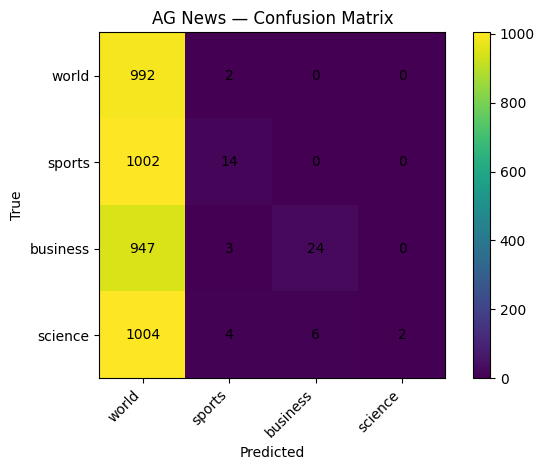

Saved best soft prompt -> best_soft_prompt_gpt2_agnews.pt


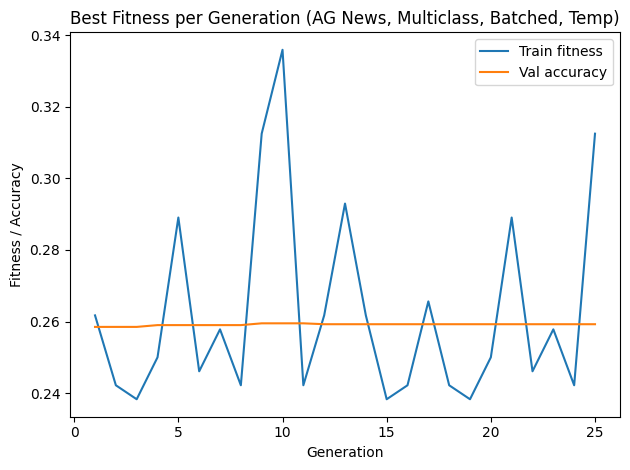

In [ ]:
# %%
# Genetic Evolution of Soft Prompts for a Frozen LLM (GPT-2) — AG News (4-class)
# -----------------------------------------------------------------------------
# Features:
#   • Multi-class labels (AG News: World, Sports, Business, Sci/Tech)
#   • Batched class scoring (all classes in one forward)
#   • Temperature for log-probs
#   • Evolutionary algorithm over a *soft prompt*; model weights are frozen
#   • Per-class accuracy + confusion matrix plot
#   • Checkpoint resume: keep best prompt so far across runs
#
# Fitness:
#   - "accuracy":   mean( argmax_k log p(label_k | x) == y )
#   - "avg_margin": mean( log p(y|x) - max_{k≠y} log p(k|x) )
#
# Colab:
#   1) Runtime -> Change runtime type -> GPU
#   2) Run the entire script
#
# MIT License (c) 2025
# -----------------------------------------------------------------------------

import os, sys, subprocess, random
from dataclasses import dataclass, asdict
from typing import List, Tuple

def pip_install(pkg):
    try:
        __import__(pkg.split(">=")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for pkg in ["transformers>=4.43.0", "datasets>=2.20.0", "accelerate>=0.33.0", "torch", "matplotlib"]:
    pip_install(pkg)

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# --------------------------- CONFIG ------------------------------------------
@dataclass
class Config:
    model_name: str = "gpt2"
    prompt_len: int = 20
    population_size: int = 30
    elite_frac: float = 0.2
    mutation_std: float = 0.02
    crossover_rate: float = 0.5
    generations: int = 25
    batch_per_gen: int = 256
    max_eval_len: int = 160   # AG News texts are short; a bit more room
    seed: int = 42
    use_half: bool = True
    final_eval_size: int = 4000

@dataclass
class SeqConfig:
    # AG News 4-class label strings; order maps 0..3 to these textual labels.
    label_strings: List[str] = None
    fitness_mode: str = "accuracy"  # "accuracy" or "avg_margin"
    temperature: float = 1.0        # >0; 1.0 = standard; >1 smoother, <1 sharper

@dataclass
class RuntimeConfig:
    resume: bool = True
    ckpt_path: str = "ea_soft_prompt_ckpt.pt"  # saved during evolution
    best_artifact_path: str = "best_soft_prompt_gpt2_agnews.pt"  # final

CFG = Config()
SEQ = SeqConfig(label_strings=[" world", " sports", " business", " science"])
RUN = RuntimeConfig()

random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

# -------------------------- DATA ---------------------------------------------
# AG News splits: 'train' and 'test'
# Label mapping (HuggingFace): 0=World, 1=Sports, 2=Business, 3=Sci/Tech
print("Loading AG News...")
ds = load_dataset("ag_news")
train_all = ds["train"]
val_all = ds["test"]

def sample_indices(n, size):
    n = min(n, size)
    return torch.randperm(size)[:n].tolist()

# Fixed validation slice for monitoring
val_idx = sample_indices(4000, len(val_all))
print(f"Validation slice size: {len(val_idx)}")

# --------------------- MODEL / TOKENIZER -------------------------------------
print(f"Loading model: {CFG.model_name}")
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(CFG.model_name)
model.eval()
for p in model.parameters():
    p.requires_grad_(False)

if device == "cuda":
    if CFG.use_half:
        model.half()
    model.to(device)

hidden_size = model.transformer.wte.weight.shape[1]
x_dtype = model.dtype
print("Hidden size:", hidden_size, "| dtype:", x_dtype)

# ---------------------- SOFT PROMPT UTILITIES --------------------------------
def init_individual() -> torch.Tensor:
    return (0.02 * torch.randn(CFG.prompt_len, hidden_size, device=device)).to(model.dtype)

def mutate(x: torch.Tensor, std: float) -> torch.Tensor:
    return x + torch.randn_like(x) * std

def crossover(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    alpha = torch.rand((), device=device, dtype=x_dtype)
    return alpha * a + (1 - alpha) * b

# --------- TASK FORMATTING & MULTICLASS FULL-SEQUENCE SCORING ----------------
label_token_lists = [tokenizer.encode(s, add_special_tokens=False) for s in SEQ.label_strings]
assert all(len(toks) > 0 for toks in label_token_lists), "Some label strings tokenized to empty!"

def build_batch(split, idxs: List[int]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # AG News features: 'text' and 'label'
    texts = [split[i]["text"] for i in idxs]
    labels = torch.tensor([split[i]["label"] for i in idxs], device=device)  # 0..3
    # Truncate and format
    texts = [t if len(t) < 4000 else t[:4000] for t in texts]
    prompts = [f"News: {t[:CFG.max_eval_len]}\nCategory:" for t in texts]
    enc = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=CFG.max_eval_len+32)
    input_ids = enc["input_ids"].to(device)
    attn = enc["attention_mask"].to(device)
    return input_ids, attn, labels

@torch.no_grad()
def multiclass_logprobs_batched(soft_prompt: torch.Tensor,
                                input_ids: torch.Tensor,
                                attention_mask: torch.Tensor,
                                label_token_lists: List[List[int]],
                                temperature: float = 1.0) -> torch.Tensor:
    """
    Returns per-example log-probs for each class label string.
    Shape: [B, K], where K = number of classes (len(label_token_lists)).

    Batches all classes into one forward pass (B*K total batch size),
    padding label sequences to the max length and masking the padding.
    """
    assert temperature > 0.0, "temperature must be > 0"
    B, T = input_ids.shape
    K = len(label_token_lists)
    Lmax = max(len(l) for l in label_token_lists)

    # Context embeddings once
    ctx_emb = model.transformer.wte(input_ids)              # [B, T, H]
    P = soft_prompt.shape[0]

    # Prepare class-wise label ids padded to Lmax
    label_ids_padded = []
    label_lens = []
    for toks in label_token_lists:
        Lk = len(toks)
        label_lens.append(Lk)
        pad = [tokenizer.pad_token_id] * (Lmax - Lk)
        label_ids_padded.append(toks + pad)
    label_ids_padded = torch.tensor(label_ids_padded, dtype=torch.long, device=device)  # [K, Lmax]

    # Tile to batch size and then reshape to (B*K, Lmax)
    label_ids_bk = label_ids_padded.unsqueeze(0).expand(B, -1, -1).contiguous()  # [B, K, Lmax]
    label_ids_bk = label_ids_bk.view(B * K, Lmax)                                 # [B*K, Lmax]

    # Embeddings
    label_emb_bk = model.transformer.wte(label_ids_bk)       # [B*K, Lmax, H]

    # Tile soft prompt and context to match B*K
    sp_bk = soft_prompt.unsqueeze(0).expand(B * K, -1, -1)   # [B*K, P, H]
    ctx_emb_bk = ctx_emb.unsqueeze(1).expand(B, K, T, ctx_emb.size(-1)).contiguous().view(B * K, T, -1)

    # Concat inputs
    inputs_embeds = torch.cat([sp_bk, ctx_emb_bk, label_emb_bk], dim=1)  # [B*K, P+T+Lmax, H]

    # Attention mask: ones for SP and CTX; for label part, ones up to Lk else zeros
    ones_sp = torch.ones(B * K, P, dtype=attention_mask.dtype, device=device)
    attn_ctx = attention_mask.unsqueeze(1).expand(B, K, T).contiguous().view(B * K, T)

    # Build label mask per (b,k) using Lk
    label_mask_bk = torch.zeros(B, K, Lmax, dtype=attention_mask.dtype, device=device)
    for k, Lk in enumerate(label_lens):
        if Lk > 0:
            label_mask_bk[:, k, :Lk] = 1
    label_mask_bk = label_mask_bk.view(B * K, Lmax)

    attn = torch.cat([ones_sp, attn_ctx, label_mask_bk], dim=1)  # [B*K, P+T+Lmax]

    # Forward pass (batched over classes)
    out = model(inputs_embeds=inputs_embeds, attention_mask=attn)
    logits = out.logits  # [B*K, P+T+Lmax, V]

    # Temperature
    if temperature != 1.0:
        logits = logits / float(temperature)

    # Compute sum of log-probs over true label tokens (ignore padded positions)
    # Predicting position for label token j is (P+T+j-1)
    logprob_bk = torch.zeros(B * K, dtype=torch.float32, device=device)
    for j in range(Lmax):
        pred_pos = P + T + j - 1
        mask_j = label_mask_bk[:, j]  # [B*K]
        if mask_j.max().item() == 0:
            continue
        step_logits = logits[:, pred_pos, :]                          # [B*K, V]
        step_logprobs = F.log_softmax(step_logits, dim=-1)            # [B*K, V]
        tok_j = label_ids_bk[:, j]                                    # [B*K]
        step_lp = step_logprobs.gather(1, tok_j.view(-1, 1)).squeeze(1)  # [B*K]
        logprob_bk = logprob_bk + step_lp * mask_j

    # Reshape back to [B, K]
    return logprob_bk.view(B, K)

@torch.no_grad()
def metrics_for_indices_multiclass(soft_prompt: torch.Tensor, split, idxs: List[int]):
    """
    Returns:
      - accuracy over idxs
      - avg_margin = mean(log p(y|x) - max_{k≠y} log p(k|x))
    """
    bs = 64
    correct = 0
    total = 0
    margins = []

    for i in range(0, len(idxs), bs):
        sub = idxs[i:i+bs]
        input_ids, attn, labels = build_batch(split, sub)  # labels in [0..K-1]
        class_logprobs = multiclass_logprobs_batched(
            soft_prompt, input_ids, attn, label_token_lists, temperature=SEQ.temperature
        )  # [B, K]

        preds = class_logprobs.argmax(dim=1)  # [B]
        correct += (preds == labels).sum().item()
        total += labels.shape[0]

        true_lp = class_logprobs.gather(1, labels.view(-1, 1)).squeeze(1)  # [B]
        K = class_logprobs.size(1)
        mask = torch.ones_like(class_logprobs, dtype=torch.bool)
        mask.scatter_(1, labels.view(-1, 1), False)
        competitor = class_logprobs.masked_fill(~mask, float("-inf")).max(dim=1).values
        margins.append((true_lp - competitor).detach().float().cpu())

    acc = correct / max(total, 1)
    avg_margin = torch.cat(margins).mean().item() if margins else 0.0
    return acc, avg_margin

@torch.no_grad()
def confusion_and_per_class_acc(soft_prompt: torch.Tensor, split, idxs: List[int], num_classes: int):
    """Return confusion matrix (KxK) and per-class accuracy vector (K)."""
    bs = 64
    cm = torch.zeros((num_classes, num_classes), dtype=torch.long)
    for i in range(0, len(idxs), bs):
        sub = idxs[i:i+bs]
        input_ids, attn, labels = build_batch(split, sub)
        class_logprobs = multiclass_logprobs_batched(
            soft_prompt, input_ids, attn, label_token_lists, temperature=SEQ.temperature
        )
        preds = class_logprobs.argmax(dim=1)
        for t, p in zip(labels.cpu().tolist(), preds.cpu().tolist()):
            cm[t, p] += 1

    per_class_acc = torch.zeros(num_classes, dtype=torch.float32)
    for k in range(num_classes):
        total_k = cm[k].sum().item()
        correct_k = cm[k, k].item()
        per_class_acc[k] = (correct_k / total_k) if total_k > 0 else 0.0
    return cm, per_class_acc

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    import numpy as np
    fig = plt.figure()
    plt.title(title)
    plt.imshow(cm, aspect='equal')
    plt.colorbar()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    # annotate counts
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(int(cm[i, j])), ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    return fig

# ------------------------ EVOLUTIONARY LOOP + CHECKPOINT ---------------------
def save_ckpt(path, best_prompt, history, gen_completed, best_val_acc):
    torch.save(
        {
            "best_soft_prompt": best_prompt.detach().float().cpu(),
            "history": history,
            "gen_completed": gen_completed,
            "best_val_acc": best_val_acc,
            "config": asdict(CFG),
            "seq_config": {"label_strings": SEQ.label_strings, "fitness_mode": SEQ.fitness_mode, "temperature": SEQ.temperature},
        },
        path,
    )

def load_ckpt(path):
    return torch.load(path, map_location="cpu")

def evolve():
    start_gen = 0
    history = []
    global_best_prompt = None
    global_best_val_acc = -1.0

    # Resume: seed population around best prompt so far
    if RUN.resume and os.path.exists(RUN.ckpt_path):
        blob = load_ckpt(RUN.ckpt_path)
        history = blob.get("history", [])
        start_gen = int(blob.get("gen_completed", 0))
        global_best_val_acc = float(blob.get("best_val_acc", -1.0))
        best_sp_cpu = blob["best_soft_prompt"]
        global_best_prompt = best_sp_cpu.to(device).to(model.dtype)
        print(f"Resuming from checkpoint @ gen {start_gen}, best val acc = {global_best_val_acc:.4f}")
        # init population from mutated copies of best
        population = [global_best_prompt.clone()]
        while len(population) < CFG.population_size:
            population.append(mutate(global_best_prompt.clone(), CFG.mutation_std))
    else:
        population = [init_individual() for _ in range(CFG.population_size)]

    fixed_val = val_idx

    for gen in range(start_gen, CFG.generations):
        train_idxs = sample_indices(CFG.batch_per_gen, len(train_all))

        fitness = []
        members = []
        for ind in population:
            acc, margin = metrics_for_indices_multiclass(ind, train_all, train_idxs)
            if SEQ.fitness_mode == "avg_margin":
                fit = margin
            else:
                fit = acc
            fitness.append(fit)
            members.append((ind, acc, margin))

        elite_k = max(1, int(CFG.elite_frac * CFG.population_size))
        ranked = sorted(zip(fitness, members), key=lambda x: x[0], reverse=True)
        elites = [pair[1][0] for pair in ranked[:elite_k]]
        best_train = ranked[0][0]

        # Validation on fixed slice
        best_elite = elites[0]
        best_val_acc, best_val_margin = metrics_for_indices_multiclass(best_elite, val_all, fixed_val)
        history.append((best_train, best_val_acc))

        print(f"Gen {gen+1:02d}/{CFG.generations} | best(train)={best_train:.3f} | "
              f"best(val_acc)={best_val_acc:.3f} | val_margin={best_val_margin:.3f} | "
              f"T={SEQ.temperature}")

        # Update global best and checkpoint
        if best_val_acc > global_best_val_acc or global_best_prompt is None:
            global_best_val_acc = best_val_acc
            global_best_prompt = best_elite.clone()
        # Save checkpoint every gen (keeps best so far)
        save_ckpt(RUN.ckpt_path, global_best_prompt, history, gen_completed=gen+1, best_val_acc=global_best_val_acc)

        # Next generation (elitism + tournament + crossover + mutation)
        new_pop = [e.clone() for e in elites]
        while len(new_pop) < CFG.population_size:
            def pick_parent():
                cand = random.sample(ranked, k=min(3, len(ranked)))
                # cand: list of (fitness, (ind, acc, margin))
                return max(cand, key=lambda x: x[0])[1][0]
            p1 = pick_parent()
            p2 = pick_parent()
            child = p1.clone()
            if random.random() < CFG.crossover_rate:
                child = crossover(p1, p2)
            child = mutate(child, CFG.mutation_std)
            new_pop.append(child)
        population = new_pop[:CFG.population_size]

    # Final: evaluate global best on large subset, plot confusion
    final_subset = sample_indices(CFG.final_eval_size, len(val_all))
    final_acc, final_margin = metrics_for_indices_multiclass(global_best_prompt, val_all, final_subset)
    print(f"\nFinal best validation accuracy (n={len(final_subset)}): {final_acc:.4f} "
          f"| avg margin: {final_margin:.4f} | T={SEQ.temperature}")

    # Confusion matrix and per-class accuracy
    cm, per_class = confusion_and_per_class_acc(global_best_prompt, val_all, final_subset, num_classes=len(SEQ.label_strings))
    class_names = [s.strip() for s in SEQ.label_strings]
    print("\nPer-class accuracy:")
    for name, acc in zip(class_names, per_class.tolist()):
        print(f"  {name:>8s}: {acc:.4f}")
    plot_confusion_matrix(cm, class_names, title="AG News — Confusion Matrix")

    # Save best artifact
    torch.save(
        {
            "soft_prompt": global_best_prompt.detach().float().cpu(),
            "config": vars(CFG),
            "seq_config": {"label_strings": SEQ.label_strings, "fitness_mode": SEQ.fitness_mode, "temperature": SEQ.temperature},
            "model_name": CFG.model_name,
            "hidden_size": hidden_size,
            "final_val_acc": float(final_acc),
            "final_val_margin": float(final_margin),
        },
        RUN.best_artifact_path,
    )
    print(f"Saved best soft prompt -> {RUN.best_artifact_path}")
    return global_best_prompt

best_prompt = evolve()

# ------------------------------ PLOT (Fitness history) -----------------------
# Re-load history from checkpoint to ensure it's present after resume
if os.path.exists(RUN.ckpt_path):
    blob = torch.load(RUN.ckpt_path, map_location="cpu")
    history = blob.get("history", [])
else:
    history = []

if history:
    train_curve = [t for (t, v) in history]
    val_curve = [v for (t, v) in history]

    plt.figure()
    plt.title("Best Fitness per Generation (AG News, Multiclass, Batched, Temp)")
    plt.plot(range(1, len(train_curve)+1), train_curve, label="Train fitness")
    plt.plot(range(1, len(val_curve)+1), val_curve, label="Val accuracy")
    plt.xlabel("Generation")
    plt.ylabel("Fitness / Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()